# Comprehensive Mapping of HIV-1 Escape from DARPins
#### Adam S. Dingens, Julie Overbaugh, and Jesse D. Bloom
#### In collaboration with Matthias Glogl, Nikolas Friedrich, and Alexandra Trkola

### Mutational antigenic profiling the DARPins using BF520 Env.

Experiments performed by Matthias Glogl, Nikolas Friedrich, Adam Dingens in the [Trkola lab](http://www.virology.uzh.ch/de/research/gtrkolad.htmll) in the autumn of 2017.

Matthias performed the inital passaing of BF520 mutant virus libraries. We then neutralized one library with PGT151 at 1 ug/mL (as a positive control when setting up mutational antigenic profiling in the Trkola group), as well as with two DARPins 6.1.G2 and 6.1.G2, each at two concentrations corresponding to an IC95 and IC99 concentration. 

Here, we will use [dms_tools2](https://jbloomlab.github.io/dms_tools2/) to analyze the data. 

We can compare all of these results to similar plots in [the dms_tools2 re-analysis of Dingens 2017](./dms_tools2/examples/Dingens2017/analysis_notebook.ipynb). 

## Import `Python` modules, define widely used functions

In [1]:
import os
import pandas
from IPython.display import display, HTML
import dms_tools2
import dms_tools2.plot
from dms_tools2.ipython_utils import showPDF
import glob

print("Using dms_tools2 version {0}".format(dms_tools2.__version__))

# results will go in this directory
resultsdir = './results/' 
if not os.path.isdir(resultsdir):
    os.mkdir(resultsdir)
    
# CPUs to use, should not exceed the number you request with slurm
ncpus = 14

# do we use existing results or generate everything new?
use_existing = 'yes'

Using dms_tools2 version 2.0a0


/home/adingens/.local/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## ./data/ files description
In [./data/](./data/), there are input datasets. These include the wildtype coding sequence of BF520.W14M.C2 [./data/BF520c2-Env.fasta](./data/BF520c2-Env.fasta). This is available as GenBank accession number [KX168094.1](https://www.ncbi.nlm.nih.gov/nuccore/KX168094.1). Also included is PGT151 mapping data from [Falkowska et al 2014](http://www.sciencedirect.com/science/article/pii/S107476131400123X), as well as a [csv file describing the conversion from BF520 numbering to HXB2 numbering](./data/BF520c2_to_HXB2.csv).

## Wrangling the FASTQ files

We will need to specify where the FASTQ files are on the server, copy and paste them to a new location here, or create symbolic links to them here. 


In [2]:
# directory for FASTQ files
#Osvaldo already greated this directory on this server and put the fastq files in it. Thanks Osvaldo!
fastqdir = './FASTQ_FILES/' 


In [3]:
#below, I manually link each FASTQ fole to two different sample names. 
#We will use the second listed name, but I provided the "name_other" as a reference to how they would have been named in Dingens 2017
samples = pandas.DataFrame.from_records(
        [('mut-virus_1', 'BF520_M1_mock', "BF520-M1-mock_S2_L001_R1_001.fastq.gz"),
         ('mut-virus_1_PGT151_1ug', 'BF520_M1_PGT151_1ug', "BF520-M1-PGT151-1ug_S7_L001_R1_001.fastq.gz"),
         ('mut-virus_1_6.1.G2_0.17uM', 'BF520_M1_6.1.G2_0.17uM', "BF520-M1-6-1-G2-0-17uM_S3_L001_R1_001.fastq.gz"),
         ('mut-virus_1_6.1.G2_0.56uM', 'BF520_M1_6.1.G2_0.56uM', "BF520-M1-6-1-G2-0-56uM_S4_L001_R1_001.fastq.gz"),
         ('mut-virus_1_112.2.C11_0.17uM', 'BF520_M1_112.2.C11_0.17uM', "BF520-M1-112-2-C11-0-17uM_S5_L001_R1_001.fastq.gz"),
         ('mut-virus_1_112.2.C11_0.56uM', 'BF520_M1_112.2.C11_0.56uM', "BF520-M1-112-2-C11-0-56uM_S6_L001_R1_001.fastq.gz"),
         ('wt-DNA', 'BF520_wt_DNA', "BF520-wt-DNA_S8_L001_R1_001.fastq.gz"),
         ('wt-virus_1', 'BF520_wt_1_mock', "BF520-wt-1-mock_S1_L001_R1_001.fastq.gz")],       
        columns=['name_other', 'name', 'R1']
        )

## Process the FASTQ files to count the mutations for each sample
[Dingens et al. 2017](http://dx.doi.org/10.1016/j.chom.2017.05.003) used [barcoded-subamplicon](https://jbloomlab.github.io/dms_tools2/bcsubamp.html) sequencing to obtain high accuracy during the Illumina deep sequencing. We therefore use the [dms2_batch_bcsubamp](https://jbloomlab.github.io/dms_tools2/dms2_batch_bcsubamp.html#dms2-batch-bcsubamp) program to analyze these data.

Running that program requires specifying a `--batchfile` that lists the samples, a wildtype `--refseq` to which we make alignments, and --alignspecs that tell us where the subamplicons should align. 
The batch file that we specify is printed by the cell below. 
The alignments are made to the wildtype BF520.W14.C2 env coding sequence described above. 
The alignment specs are specified based on the exact primers used for the barcoded-subamplicon sequencing by [Dingens et al. 2017](http://dx.doi.org/10.1016/j.chom.2017.05.003). 
The alignment specs need to be exactly correct for the subamplicons to align.

We also do some trimming of the reads using the `--R1trim` and `--R2trim` parameters. 
Such trimming can be crucial for getting good results, since the read quality often drops off at the end of reads. 
Below, we have trimmed all subamplicons equally, but in some cases you might want to trim each one differently by specifying a list of values for each subamplicon.

The wildtype sequence of the BF520 Env used in this experiment is in the file [./data/BF520c2-Env.fasta](./data/BF520c2-Env.fasta).

We can look back at the original MiSeq run with this library for an alignment paramter stating point. For this library, the R1 nd R2 lengths must sum to 417 to cover the longest amplicon.

In [4]:
#first, we must rename the sample names, as underscores are not allowed in argument
samples["name"] = samples["name"].replace('_', '-', regex=True)
samples["name"] = samples["name"].replace('\.', '-', regex=True)
samples

,name_other,name,R1
0,mut-virus_1,BF520-M1-mock,BF520-M1-mock_S2_L001_R1_001.fastq.gz
1,mut-virus_1_PGT151_1ug,BF520-M1-PGT151-1ug,BF520-M1-PGT151-1ug_S7_L001_R1_001.fastq.gz
2,mut-virus_1_6.1.G2_0.17uM,BF520-M1-6-1-G2-0-17uM,BF520-M1-6-1-G2-0-17uM_S3_L001_R1_001.fastq.gz
3,mut-virus_1_6.1.G2_0.56uM,BF520-M1-6-1-G2-0-56uM,BF520-M1-6-1-G2-0-56uM_S4_L001_R1_001.fastq.gz
4,mut-virus_1_112.2.C11_0.17uM,BF520-M1-112-2-C11-0-17uM,BF520-M1-112-2-C11-0-17uM_S5_L001_R1_001.fastq.gz
5,mut-virus_1_112.2.C11_0.56uM,BF520-M1-112-2-C11-0-56uM,BF520-M1-112-2-C11-0-56uM_S6_L001_R1_001.fastq.gz
6,wt-DNA,BF520-wt-DNA,BF520-wt-DNA_S8_L001_R1_001.fastq.gz
7,wt-virus_1,BF520-wt-1-mock,BF520-wt-1-mock_S1_L001_R1_001.fastq.gz


In [5]:
# file containing wildtype BF520 env sequence, written by this notebook above
refseq = './data/BF520c2-Env.fasta'

# define subamplicon alignment specifications
alignspecs = ' '.join(['88,417,40,39', 
                       '418,753,39,35',
                       '754,1092,36,39',
                       '1093,1447,35,29',
                       '1407,1758,35,32',
                       '1759,2097,30,36'])

# counts and alignments placed in this directory
countsdir = os.path.join(resultsdir, 'codoncounts')
if not os.path.isdir(countsdir):
    os.mkdir(countsdir)
    
# write sample information to a batch file for dms2_batch_bcsubamplicons
countsbatchfile = os.path.join(countsdir, 'batch.csv')
print("Here is the batch file that we write to CSV format to use as input:")
display(HTML(samples.to_html(index=False)))
samples.to_csv(countsbatchfile, index=False)

print('\nNow running dms2_batch_bcsubamp...')
log = !dms2_batch_bcsubamp \
        --batchfile {countsbatchfile} \
        --refseq {refseq} \
        --alignspecs {alignspecs} \
        --outdir {countsdir} \
        --summaryprefix summary \
        --R1trim 232 \
        --R2trim 185 \
        --fastqdir {fastqdir} \
        --ncpus {ncpus} \
        --use_existing {use_existing} 

print("Completed dms2_batch_bcsubamp.")

Here is the batch file that we write to CSV format to use as input:


name_other,name,R1
mut-virus_1,BF520-M1-mock,BF520-M1-mock_S2_L001_R1_001.fastq.gz
mut-virus_1_PGT151_1ug,BF520-M1-PGT151-1ug,BF520-M1-PGT151-1ug_S7_L001_R1_001.fastq.gz
mut-virus_1_6.1.G2_0.17uM,BF520-M1-6-1-G2-0-17uM,BF520-M1-6-1-G2-0-17uM_S3_L001_R1_001.fastq.gz
mut-virus_1_6.1.G2_0.56uM,BF520-M1-6-1-G2-0-56uM,BF520-M1-6-1-G2-0-56uM_S4_L001_R1_001.fastq.gz
mut-virus_1_112.2.C11_0.17uM,BF520-M1-112-2-C11-0-17uM,BF520-M1-112-2-C11-0-17uM_S5_L001_R1_001.fastq.gz
mut-virus_1_112.2.C11_0.56uM,BF520-M1-112-2-C11-0-56uM,BF520-M1-112-2-C11-0-56uM_S6_L001_R1_001.fastq.gz
wt-DNA,BF520-wt-DNA,BF520-wt-DNA_S8_L001_R1_001.fastq.gz
wt-virus_1,BF520-wt-1-mock,BF520-wt-1-mock_S1_L001_R1_001.fastq.gz



Now running dms2_batch_bcsubamp...
Completed dms2_batch_bcsubamp.


Now we look at the summary plots created by `dms2_batch_bcsubamp`. All of these files are found in the directory specified by --outdir, and with the prefix specified by summaryprefix. So we define them using this plot prefix plus the suffix for each plot.

Note that these files still all use the BF520 numbering system. 

In [10]:
countsplotprefix = os.path.join(countsdir, 'summary')

The `*_readstats.pdf` plot below shows the statistics on the reads. This plot shows that most of the reads were retained, and a small fraction discarded because of low-quality barcodes. None failed the Illumina filter as those were already filtered out those when we downloaded from the SRA using fastq-dump.

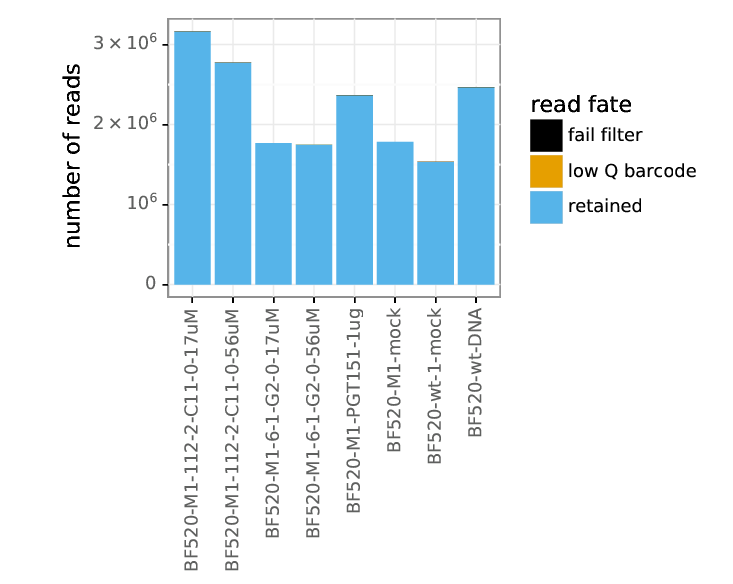

In [43]:
showPDF(countsplotprefix + '_readstats.pdf')

The `*_readsperbc.pdf` plot below shows how many times different barcodes were observed for each sample. Barcodes need to be observed multiple times to be useful for barcoded-subamplicon sequencing error correction.

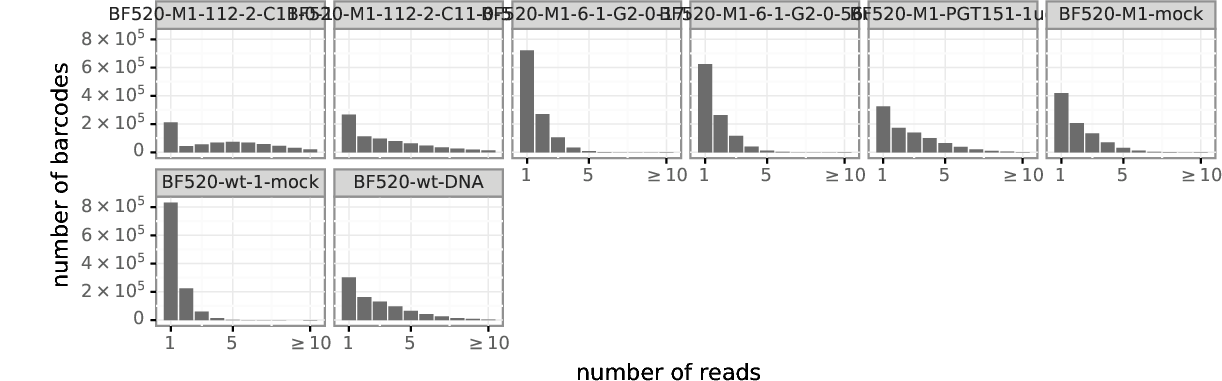

In [44]:
showPDF(countsplotprefix + '_readsperbc.pdf')

The `*_bcstats.pdf` plot below shows statistics on the barcodes. Some of the barcodes had to be discarded because they had too few reads (these are the single-read barcodes in the plot above), a small fraction with adequate reads were not alignable, and the rest aligned to the env gene properly.

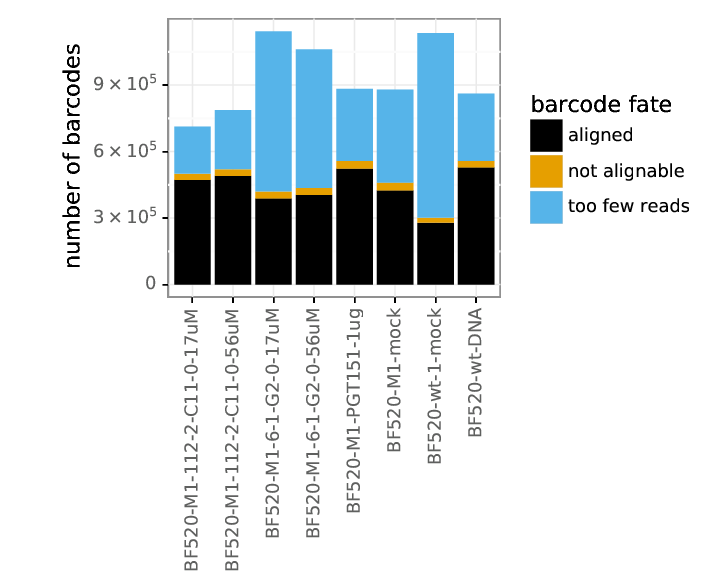

In [45]:
showPDF(countsplotprefix + '_bcstats.pdf')

The `*_depth.pdf` plot below shows the depth (number of called codons) at each site in the gene. For most of the samples, the depth across the gene is is not very uniform, indicating that the subamplicons were not pooled very evenly.
Specifically, I am concerned about the low sequencing depth for the 5th subamplicon for the mock selected sample. 

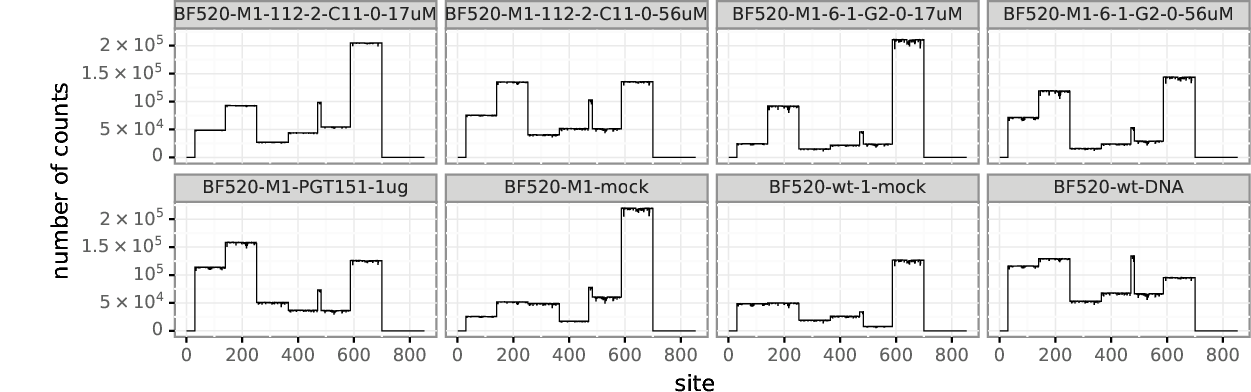

In [46]:
showPDF(countsplotprefix + '_depth.pdf')

The `*_mutfreq.pdf` plot below shows the per-codon frequency of mutations at each site. For the PGT151-selected sample, we see a few sites of clear peaks in mutation frequency, which represent the sites where antibody-escape mutations are selected. There are only small peack for the mock sample, similar as to what we have seen before. These may represent TC culture adaptations. For the DARPin selected sample, we see peaks that are similar (but to different extents) in eash selection of a given DARPin at different concentrations.

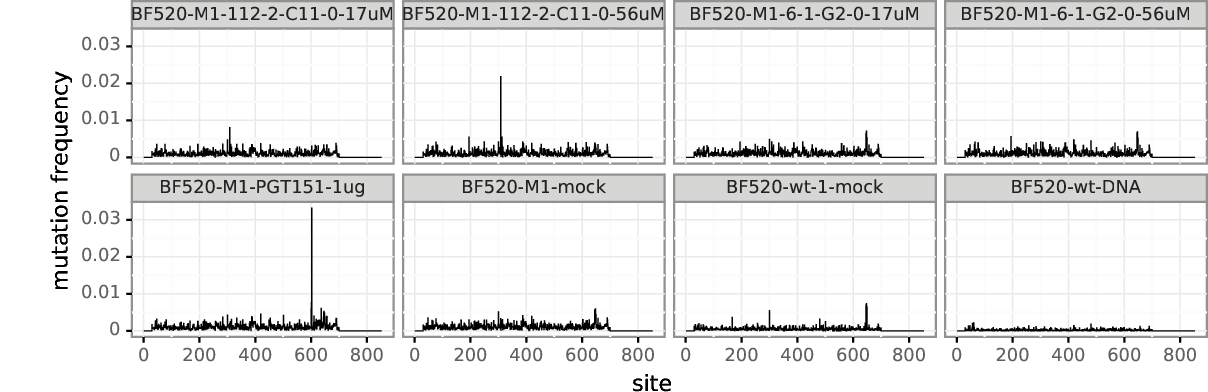

In [47]:
showPDF(countsplotprefix + '_mutfreq.pdf')

The `*_codonmuttypes.pdf` plot below shows the per-codon frequency of nonsynonymous, synonymous, and stop codon mutations across the entire gene. For the selected samples, we see an overall increase in the per-codon mutation frequency due to very strong selection for variants with escape mutations.

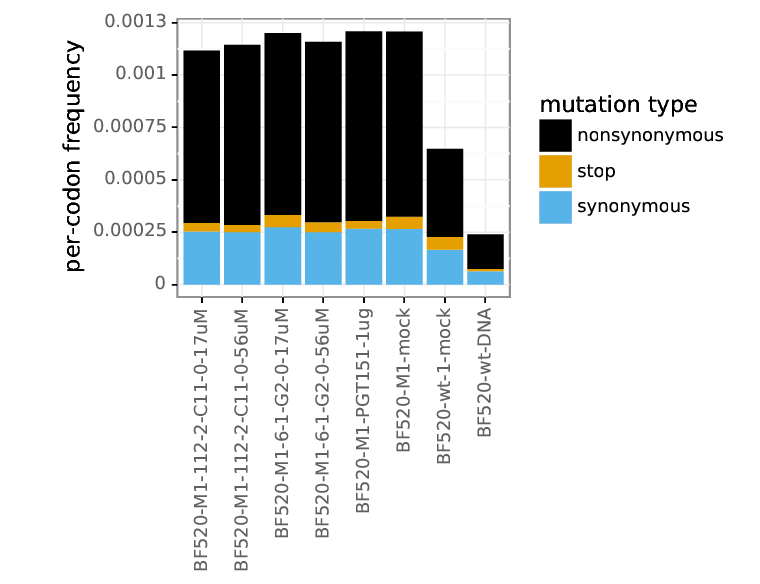

In [48]:
showPDF(countsplotprefix + '_codonmuttypes.pdf')

The `*_codonntchanges.pdf` plot below shows same data as above but categorizes codon mutations by the number of nucleotides that are changed (e.g., ATG to AAG changes 1 nucleotide, ATG to AAC changes 2 nucleotides, and ATG to CAC changes 3 nucleotides).

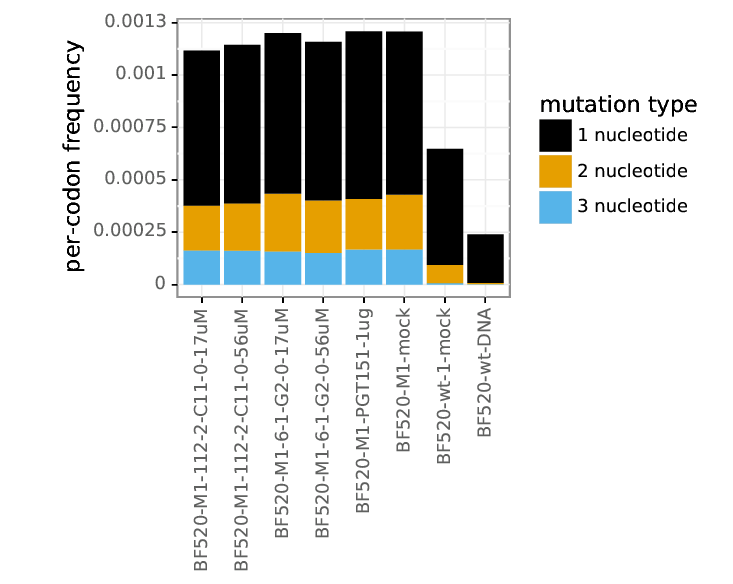

In [49]:
showPDF(countsplotprefix + '_codonntchanges.pdf')

The `*_singlentchanges.pdf` plot below shows the frequency of each type of nucleotide change among only codon mutations with one nucleotide change. This plot is mostly useful to check if there is a large bias in which mutations appear. In particular, if you are getting oxidative damage (which causes G to T mutations) during the library preparation process, you will see a large excess of C to A or G to T mutations (or both). There is not much oxidative damage in the samples plotted below, which mostly have a fairly even distribution of nucleotide changes.

We do see that transitions (G <-> A and C <-> T) are a bit more common than most of the other types of mutations (all of which are transversions). This is expected, since [PCR based sources of mutations are expected to preferentially introduce transitions](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3720931/). 

This plot would also be important to examine any sign of APOBEC hypermutation (also G <-> A, with preferences for specific motifs) occuring in the HIV genome. One of the reasons we selected the SupT1.R5 cell line was because [there is very little of the APOBEC proteins expressed in  a subclone of SupT1 cells](https://www.ncbi.nlm.nih.gov/pubmed/20308164). In the viral samples, there does appear to be an increase in G to A and C to T mutations. However, we passaged WT virus in these cells and confirmed there were not signs of extensive APOBEC hypermutation in hotspot motifs via deep sequencing of env after passaging. Thus, we do not think there is extensive APOBEC hypermutation in our data, and this increase certain types of mutations in the viral samples is likely due to bias in the viral reverse transcription.

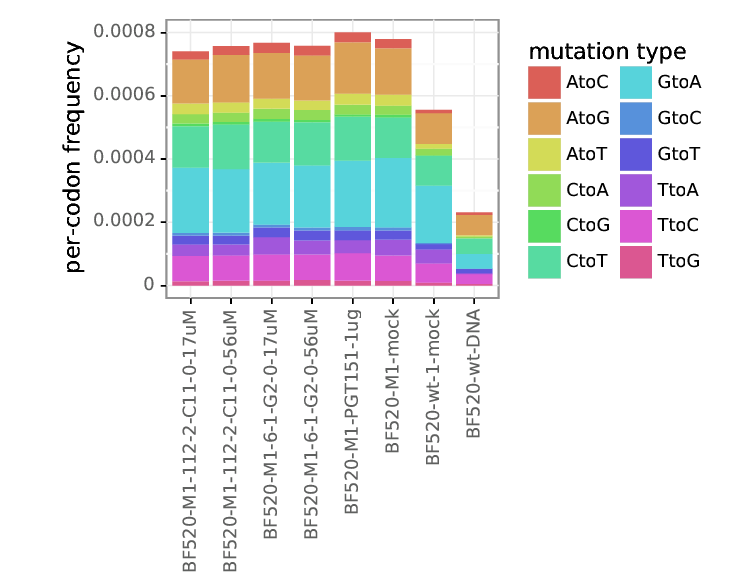

In [50]:
showPDF(countsplotprefix + '_singlentchanges.pdf')

## Renumber codon counts to HXB2 numbering 
The standard numbering scheme for HIV Env is the [HXB2 numbering scheme](https://www.hiv.lanl.gov/content/sequence/HIV/REVIEWS/HXB2.html).
The file [./data/BF520c2_to_HXB2.csv](./data/BF520c2_to_HXB2.csv) gives the mapping from sequential 1, 2, ... numbering of the BF520 protein sequence to the HXB2 numbering scheme. 
This file was generated by aligning the HXB2 sequence [taken from Genbank](http://www.ncbi.nlm.nih.gov/protein/1906385) with the BF520c2 sequence using the [LANL alignment interface](http://www.hiv.lanl.gov/cgi-bin/VIRALIGN/viralign.cgi) at the protein sequence level. 
Insertions relative to HXB2 are given letter suffixes as [described here](http://www.hiv.lanl.gov/content/sequence/HIV/REVIEWS/HXB2.html).

Additionally, not all residues in BF520 Env were mutagenized. 
The N-terminal signal peptide and the C-terminal cytoplasmic tail were excluded because they seem likely to affect expression level. 
These sites are not listed in the renumbering file, and so are dropped when we do the re-numbering.

To do the re-numbering, we use the [dms_tools2.utils.renumberSites](https://jbloomlab.github.io/dms_tools2/dms_tools2.utils.html#dms_tools2.utils.renumberSites) function from the [dms_tools Python API](https://jbloomlab.github.io/dms_tools2/api.html) to create a new directory that contains all of the re-numbered files with the same name as in the original codon counts directory produced above.

In [12]:
renumberedcountsdir = os.path.join(resultsdir, 'renumberedcounts')
if not os.path.isdir(renumberedcountsdir):
    os.mkdir(renumberedcountsdir)
countsfiles = glob.glob('{0}/*codoncounts.csv'.format(countsdir))
renumberfile = "./data/BF520c2_to_HXB2.csv"
dms_tools2.utils.renumberSites(renumberfile, countsfiles, missing='drop', outdir=renumberedcountsdir)

## Compute the differential selection and correlations between replicates
Now we compute the [differential selection](https://jbloomlab.github.io/dms_tools2/diffsel.html) from PGT151 antibody for each replicate, using the *wt-virus* controls to estimate the error rates.
We also compute the average differential selection across replicates.


We first create a batch file to use with dms2_batch_diffsel. Note that, in the future, we can make the group arguments the antibody, the name argument the replicate, and assign the sel, mock, and err arguments based on the names used for the batch file when generating the counts files above with dms2_batch_bcsubamp. This will then average different replicates of the same antibody and concentration. An example is in the first cell below, which does not run in this notebook by design.

All PGT151 selected samples were neutralized at 1 ug/mL of PGT151. We simply use 1ug to specify this concentration, as special characters (such as /) that are not allowed in the group argument. Note that we only have one group. 

In [6]:
# Here is an example of how we would submit these jobs if we had replicates.
#using the "group" varaible, we would group multiple replicates together. 

Do Not Run this code yet! We don't have replicate!

diffseldir = os.path.join(resultsdir, 'diffsel')
if not os.path.isdir(diffseldir):
    os.mkdir(diffseldir)
    
diffselbatchfile = os.path.join(diffseldir, 'batch.csv')


diffselbatch = pandas.DataFrame.from_records([
         ('PGT151-1ug', 'replicate-1', 'BF520-M1-PGT151-1ug', 'BF520-M1-mock', 'BF520-wt-1-mock',), 
         ('6-1-G2-0-17uM', 'replicate-1', 'BF520-M1-6-1-G2-0-17uM', 'BF520-M1-mock', 'BF520-wt-1-mock',),
         ('6-1-G2-0-17uM', 'replicate-2', 'BF520-M2-6-1-G2-0-17uM', 'BF520-M2-mock', 'BF520-wt-2-mock',),
         ('6-1-G2-0-56uM', 'replicate-1', 'BF520-M1-6-1-G2-0-56uM', 'BF520-M1-mock', 'BF520-wt-1-mock',),
         ('112-2-C11-0-17uM', 'replicate-1', 'BF520-M1-112-2-C11-0-17uM', 'BF520-M1-mock', 'BF520-wt-1-mock',),
         ('112-2-C11-0-56uM', 'replicate-1', 'BF520-M1-112-2-C11-0-56uM', 'BF520-M1-mock', 'BF520-wt-1-mock',),
        ],       
        columns=['group', ' name', 'sel', 'mock', 'err']
        )

print("Here is the batch file that we write to CSV format to use as input:")
display(HTML(diffselbatch.to_html(index=False)))

diffselbatch.to_csv(diffselbatchfile, index=False)

SyntaxError: invalid syntax (<ipython-input-6-852de40c8a4e>, line 4)

In [22]:
# put diffsel values here

diffseldir = os.path.join(resultsdir, 'diffsel')
if not os.path.isdir(diffseldir):
    os.mkdir(diffseldir)
    
diffselbatchfile = os.path.join(diffseldir, 'batch.csv')

diffselbatch = pandas.DataFrame.from_records([
         ('PGT151-1ug', 'BF520-M1-PGT151-1ug', 'BF520-M1-mock', 'BF520-wt-1-mock',), 
         ('6-1-G2-0-17uM', 'BF520-M1-6-1-G2-0-17uM', 'BF520-M1-mock', 'BF520-wt-1-mock',),
         ('6-1-G2-0-56uM', 'BF520-M1-6-1-G2-0-56uM', 'BF520-M1-mock', 'BF520-wt-1-mock',),
         ('112-2-C11-0-17uM', 'BF520-M1-112-2-C11-0-17uM', 'BF520-M1-mock', 'BF520-wt-1-mock',),
         ('112-2-C11-0-56uM', 'BF520-M1-112-2-C11-0-56uM', 'BF520-M1-mock', 'BF520-wt-1-mock',),
         ],columns=['name', 'sel', 'mock', 'err']
        )

print("Here is the batch file that we write to CSV format to use as input:")
display(HTML(diffselbatch.to_html(index=False)))

diffselbatch.to_csv(diffselbatchfile, index=False)

Here is the batch file that we write to CSV format to use as input:


name,sel,mock,err
PGT151-1ug,BF520-M1-PGT151-1ug,BF520-M1-mock,BF520-wt-1-mock
6-1-G2-0-17uM,BF520-M1-6-1-G2-0-17uM,BF520-M1-mock,BF520-wt-1-mock
6-1-G2-0-56uM,BF520-M1-6-1-G2-0-56uM,BF520-M1-mock,BF520-wt-1-mock
112-2-C11-0-17uM,BF520-M1-112-2-C11-0-17uM,BF520-M1-mock,BF520-wt-1-mock
112-2-C11-0-56uM,BF520-M1-112-2-C11-0-56uM,BF520-M1-mock,BF520-wt-1-mock


Now we simply run dms2_batch_diffsel, getting the input counts from the directory (--indir) that we placed the counts when we ran dms2_batch_bcsubamp.

In [23]:
log = !dms2_batch_diffsel \
        --summaryprefix summary \
        --batchfile {diffselbatchfile} \
        --outdir {diffseldir} \
        --indir {renumberedcountsdir} \
        --use_existing {use_existing}

Running this command creates a large number of output files giving the mutation and site differential selection values in the formats of the `mutdiffsel.csv` and `sitediffsel.csv` files created by `dms2_diffsel`. These include:

In [18]:
!ls {diffseldir}/*.csv

./results/diffsel/112-2-C11-0-17uM_mutdiffsel.csv
./results/diffsel/112-2-C11-0-17uM_sitediffsel.csv
./results/diffsel/112-2-C11-0-56uM_mutdiffsel.csv
./results/diffsel/112-2-C11-0-56uM_sitediffsel.csv
./results/diffsel/6-1-G2-0-17uM_mutdiffsel.csv
./results/diffsel/6-1-G2-0-17uM_sitediffsel.csv
./results/diffsel/6-1-G2-0-56uM_mutdiffsel.csv
./results/diffsel/6-1-G2-0-56uM_sitediffsel.csv
./results/diffsel/batch.csv
./results/diffsel/PGT151-1ug_mutdiffsel.csv
./results/diffsel/PGT151-1ug_sitediffsel.csv
./results/diffsel/summary_meanmutdiffsel.csv
./results/diffsel/summary_meansitediffsel.csv
./results/diffsel/summary_medianmutdiffsel.csv
./results/diffsel/summary_mediansitediffsel.csv


### Examine correlation between the same library neutralized with two different concentrations of the same DARPin
Here, we can pass the two samples neutralized by the same DARPin, but at different concentrations, as a group. The output will be put in a seperate diffsel subdirectory [./results/diffsel/avg_across_concentrations](./results/diffsel/avg_across_concentrations). This will show another example of using the `group` option, allow us to examine correlation between these replicates, and average the two technical replicates doen at different concentrations of DARpin. Note that in the future, you might `name` different replicates (rather than concentrations) of the same `group`.

In [11]:
# put diffsel values here

avgconcdiffseldir = os.path.join(resultsdir, 'diffsel/avg_across_concentrations')
if not os.path.isdir(avgconcdiffseldir):
    os.mkdir(avgconcdiffseldir)
    
avgconcdiffselbatchfile = os.path.join(avgconcdiffseldir, 'batch.csv')


avgconcdiffselbatch = pandas.DataFrame.from_records([
         ('PGT151', '1ug', 'BF520-M1-PGT151-1ug', 'BF520-M1-mock', 'BF520-wt-1-mock',), 
         ('6-1-G2', '0-17uM', 'BF520-M1-6-1-G2-0-17uM', 'BF520-M1-mock', 'BF520-wt-1-mock',),
         ('6-1-G2', '0-56uM', 'BF520-M1-6-1-G2-0-56uM', 'BF520-M1-mock', 'BF520-wt-1-mock',),
         ('112-2-C11', '0-17uM', 'BF520-M1-112-2-C11-0-17uM', 'BF520-M1-mock', 'BF520-wt-1-mock',),
         ('112-2-C11', '0-56uM', 'BF520-M1-112-2-C11-0-56uM', 'BF520-M1-mock', 'BF520-wt-1-mock',),
        ],       
        columns=['group', ' name', 'sel', 'mock', 'err']
        )

print("Here is the batch file that we write to CSV format to use as input:")
display(HTML(avgconcdiffselbatch.to_html(index=False)))

avgconcdiffselbatch.to_csv(avgconcdiffselbatchfile, index=False)

Here is the batch file that we write to CSV format to use as input:


group,name,sel,mock,err
PGT151,1ug,BF520-M1-PGT151-1ug,BF520-M1-mock,BF520-wt-1-mock
6-1-G2,0-17uM,BF520-M1-6-1-G2-0-17uM,BF520-M1-mock,BF520-wt-1-mock
6-1-G2,0-56uM,BF520-M1-6-1-G2-0-56uM,BF520-M1-mock,BF520-wt-1-mock
112-2-C11,0-17uM,BF520-M1-112-2-C11-0-17uM,BF520-M1-mock,BF520-wt-1-mock
112-2-C11,0-56uM,BF520-M1-112-2-C11-0-56uM,BF520-M1-mock,BF520-wt-1-mock


In [12]:
log = !dms2_batch_diffsel \
        --summaryprefix summary \
        --batchfile {avgconcdiffselbatchfile} \
        --outdir {avgconcdiffseldir} \
        --indir {renumberedcountsdir} \
        --use_existing {use_existing}

In addition to outputting  `mutdiffsel.csv` and `sitediffsel.csv` as before, there are also now  also files giving the mean and median differential selection for all samples in each group. 
These files are prefixed with the name given by `--summaryprefix` (in this case, summary), and also indicate the group. For example, for the `6-1-G2` group, there are now:

In [23]:
!ls {avgconcdiffseldir}/summary*6-1-G2*.csv

./results/diffsel/avg_across_concentrations/summary_6-1-G2-meanmutdiffsel.csv
./results/diffsel/avg_across_concentrations/summary_6-1-G2-meansitediffsel.csv
./results/diffsel/avg_across_concentrations/summary_6-1-G2-medianmutdiffsel.csv
./results/diffsel/avg_across_concentrations/summary_6-1-G2-mediansitediffsel.csv


Now we are going to look at the correlation of samples within each group. 

Running [dms2_batch_diffsel](https://jbloomlab.github.io/dms_tools2/dms2_batch_diffsel.html#dms2-batch-diffsel) creates plots showing how the differential selection estimates for each site / mutation correlate among replicates. 
These plots have names like `summary_PGT151-1ug-mutdiffselcorr.pdf`. 
Below we show the plots for mutdiffsel and positivesitediffsel (ones are also made for absolutesitediffsel and maxsitediffsel, but are not shown below as they are less informative for this experiment). 
Note that the plots show the correlations between all pairs, and also on the diagonal show the density of the different selection values for each replicates (most of them are close to zero).


mutdiffsel correlations:


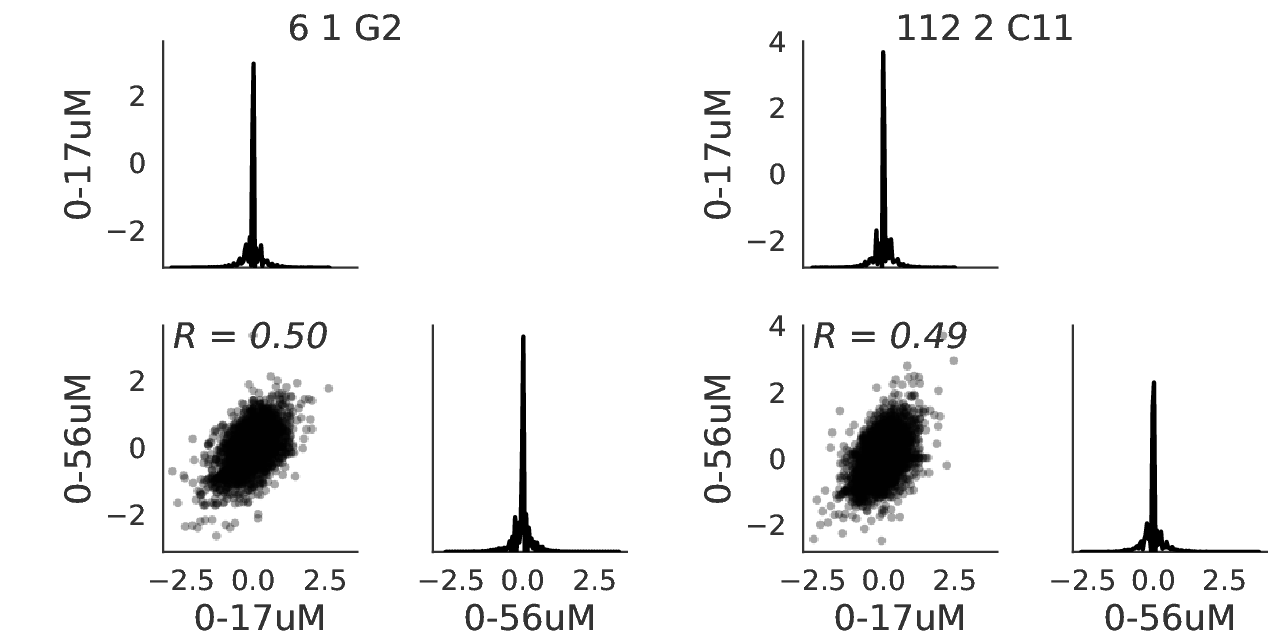


positivesitediffsel correlations:


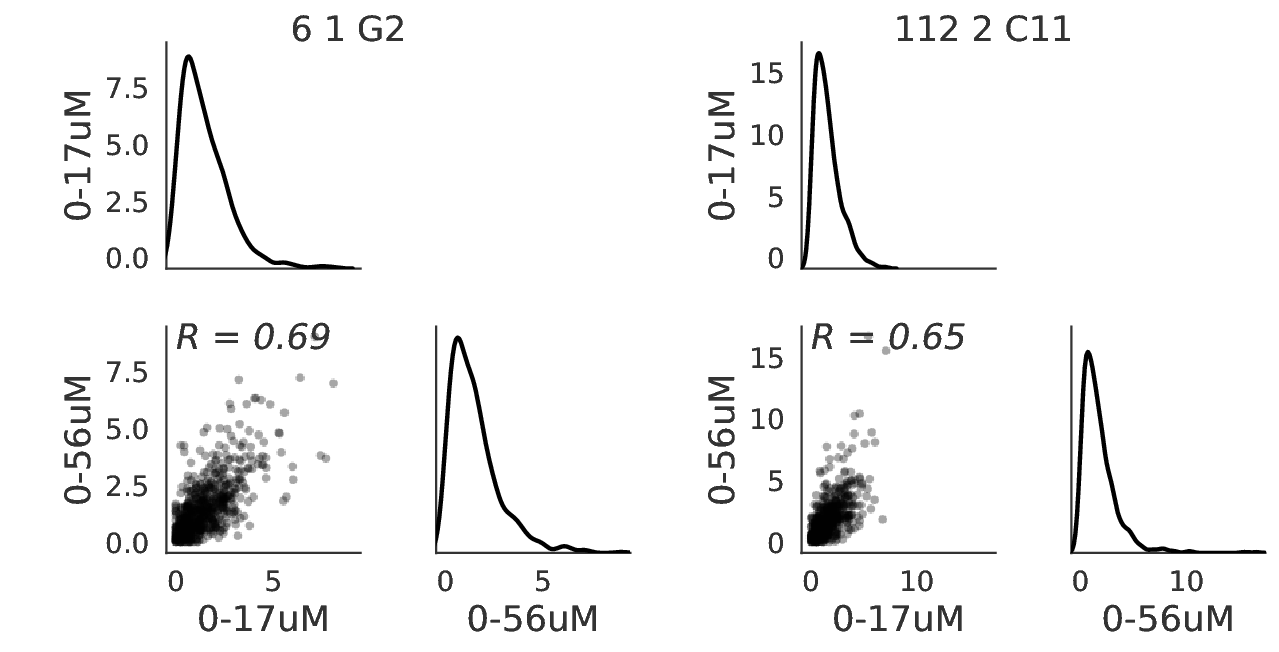

In [25]:
avgdiffselprefix = os.path.join(avgconcdiffseldir, 'summary_')
groups = avgconcdiffselbatch['group'].unique()
#since there is no PGT151 summary (because there was only 1 sample), I will alter this list
groups = ['6-1-G2', '112-2-C11']


for seltype in ['mutdiffsel', 'positivesitediffsel']:
    print("\n{0} correlations:".format(seltype))
    plots = []
    for g in groups:
        plot = avgdiffselprefix + g + '-' + seltype + 'corr.pdf'
        plots.append(plot)
    showPDF(plots, width=400) 

We can also look at the correlation between all samples below. Note that the best correlated samples are the samples of the same DARPin at different conentrations, already plotted above.


mutdiffsel correlations:


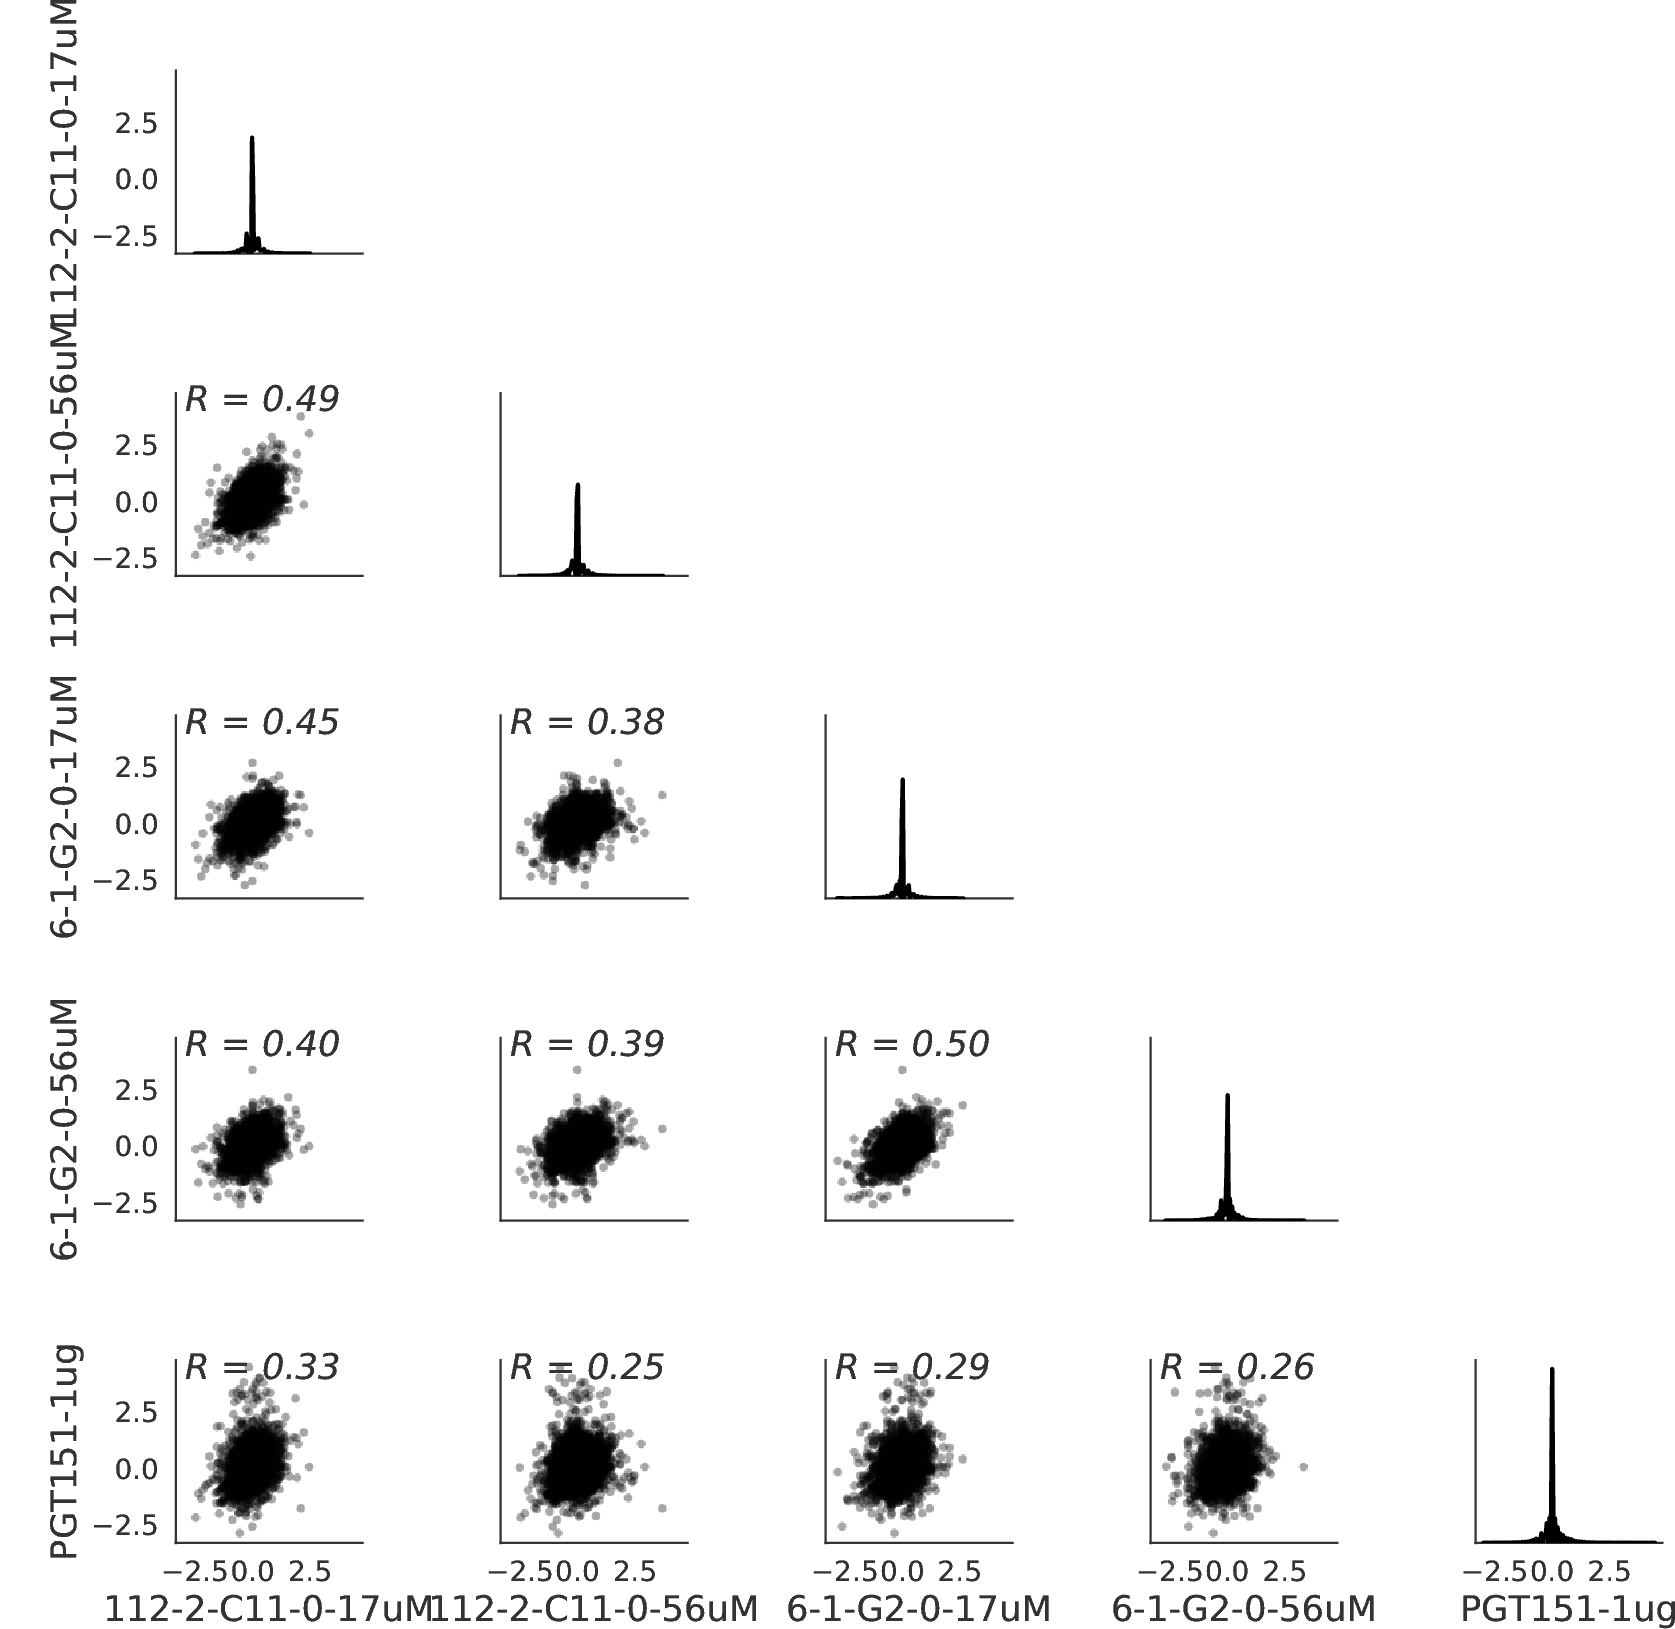


positivesitediffsel correlations:


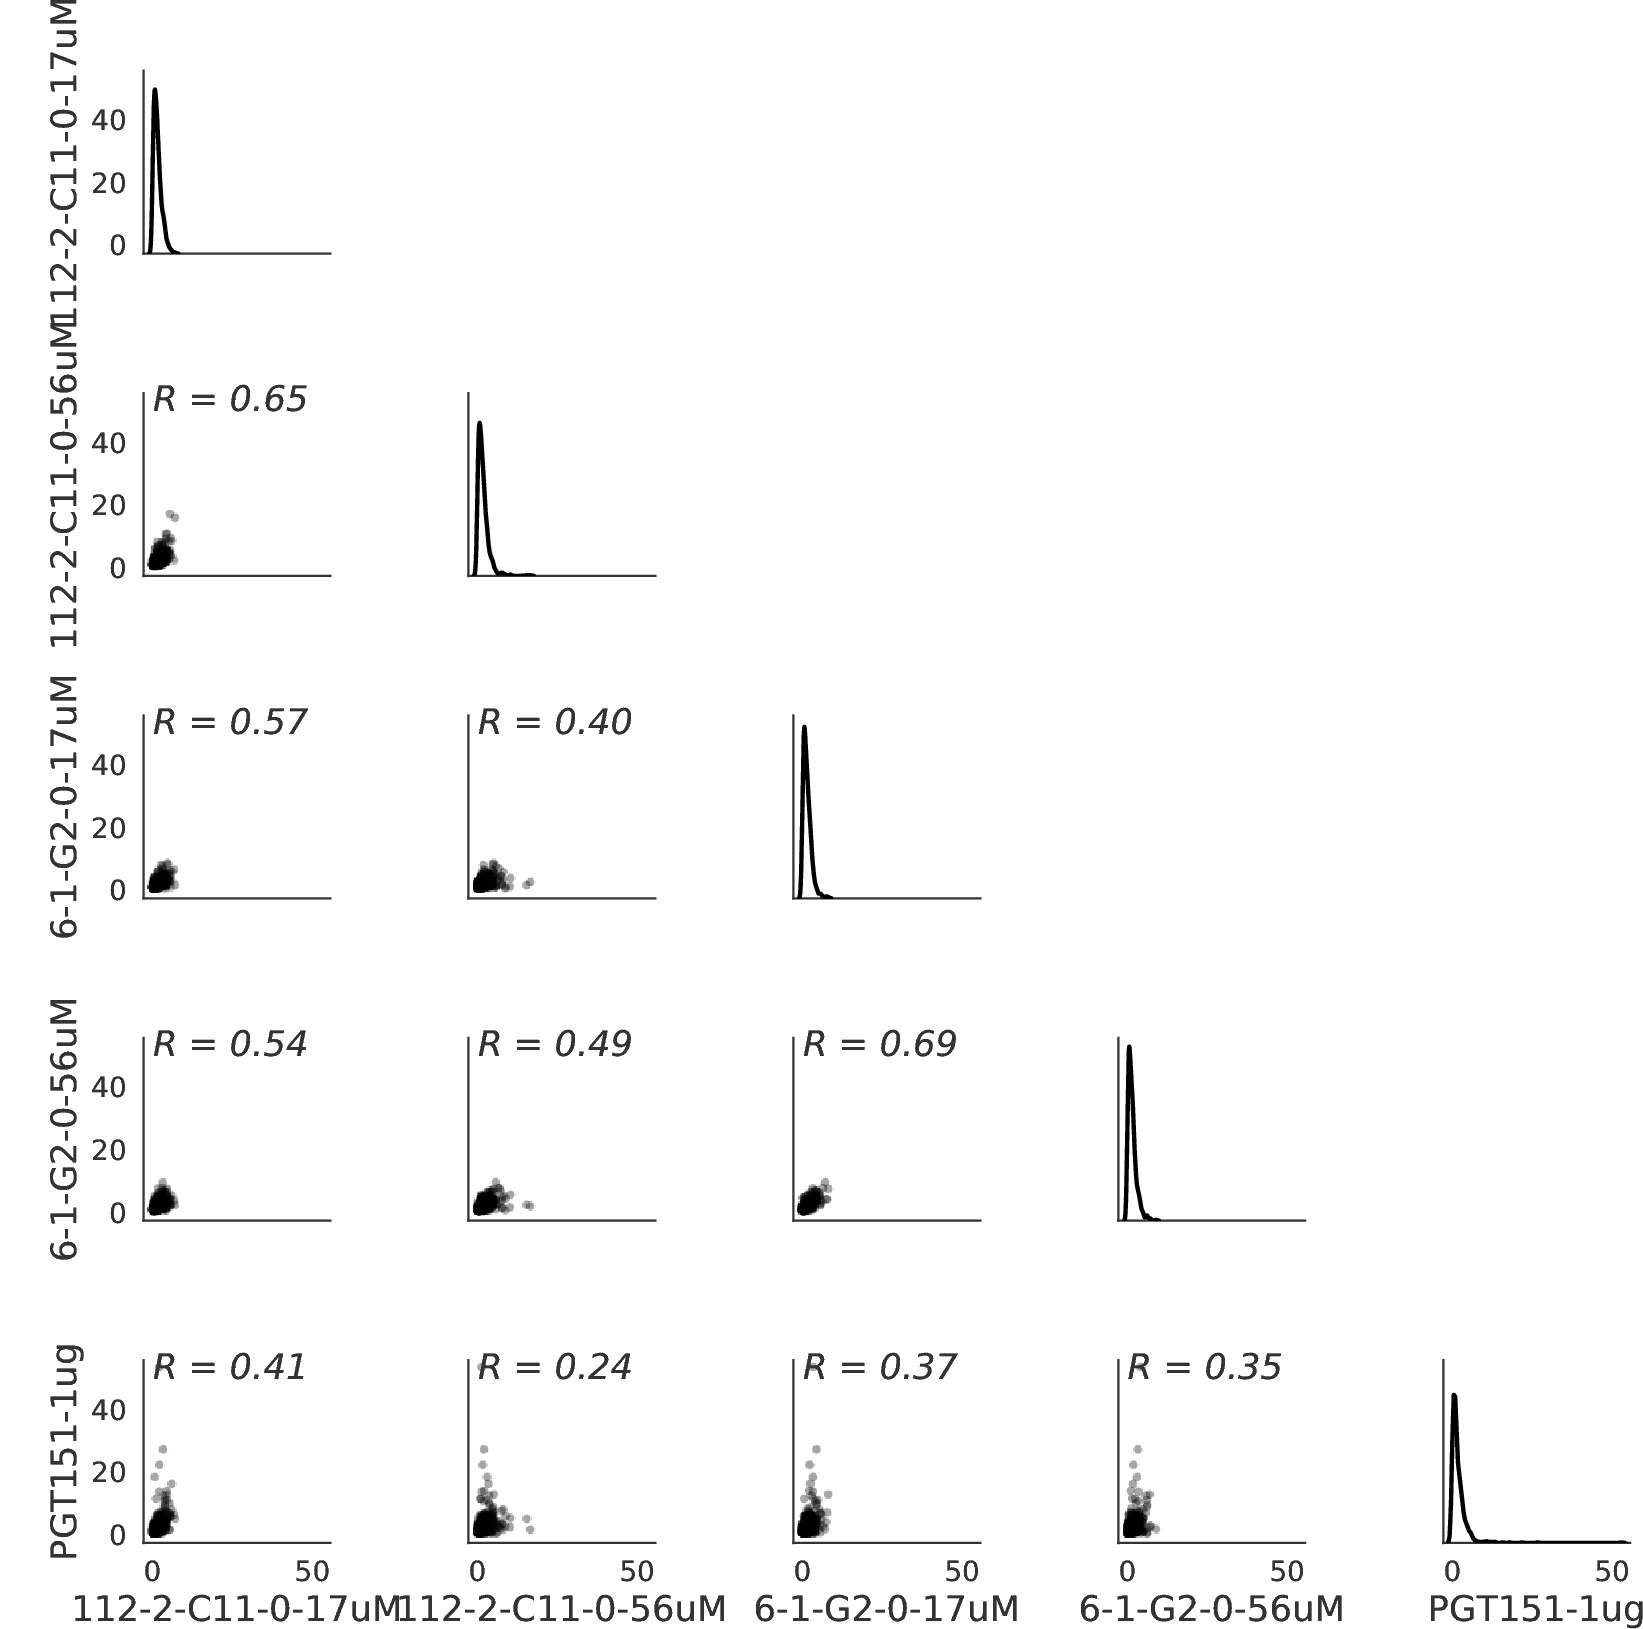

In [26]:
diffselprefix = os.path.join(diffseldir, 'summary_')
#names = diffselbatch['name'].unique()

for seltype in ['mutdiffsel', 'positivesitediffsel']:
    print("\n{0} correlations:".format(seltype))
    plots = []
    #for n in names:
    plot = diffselprefix + seltype + 'corr.pdf'
    plots.append(plot)
    showPDF(plots, width=600) 

Now we look at the differential selection along the primary sequence. Several plots showing this kind of selection are made by `dms2_batch_diffsel`. These plots show either the mean or the median differential selection among all samples in each group (CSV files have been created containing this differential selection as described above).

These files all have the prefix indicated by --summaryprefix, and show the positive differential selection, total site differential selection (both positive and negative), the maximum differential selection, and the minimum and maximum differential selection. Here are all the files created by this analysis:

In [30]:
!ls {diffseldir}/*diffsel.pdf

./results/diffsel/summary_meanmaxdiffsel.pdf
./results/diffsel/summary_meanminmaxdiffsel.pdf
./results/diffsel/summary_meanpositivediffsel.pdf
./results/diffsel/summary_meantotaldiffsel.pdf
./results/diffsel/summary_medianmaxdiffsel.pdf
./results/diffsel/summary_medianminmaxdiffsel.pdf
./results/diffsel/summary_medianpositivediffsel.pdf
./results/diffsel/summary_mediantotaldiffsel.pdf


For this particular experiment, the median and mean values, averaged across the two technical replicates, look the same, as there are only two replicates. But for some experiments one might look a lot better than another if there are clear outlier measurements in some samples. For instance, below are the mean and median side-by-side for the total site differential selection (note how this plot shows both the positive and negative values, with the mean values at left and the median values at right):

In [1]:
showPDF([avgdiffselprefix + 'meantotaldiffsel.pdf', avgdiffselprefix + 'meadiantotaldiffsel.pdf'])

NameError: name 'showPDF' is not defined

Probably the most informative plot is simply the mean positive site differential selection -- as shown in Dingens et al 2017. This plot shows the total positive selection for all mutations combined at a given site, and is shown below:

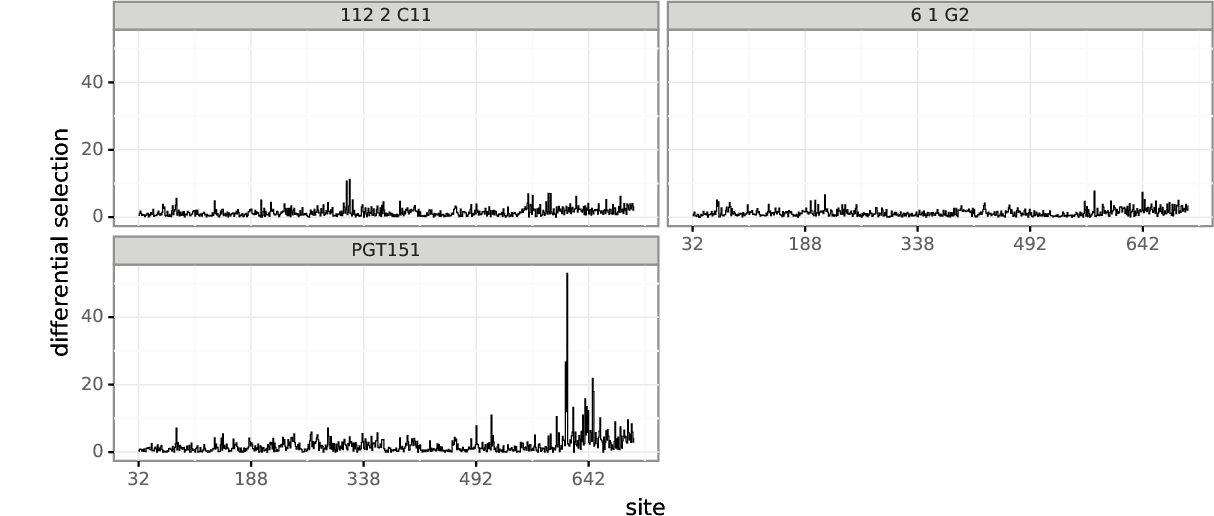

In [38]:
showPDF(diffselprefix + 'meanpositivediffsel.pdf', width=800)

Another plot that can sometimes be useful is the maximum mutation differential selection at each site. This measurement is more noisy, but it tells us how strong is the selection for the most favorable mutation at that site, so better detects sites where only one mutation might be substantially favored. Below we plot the mean an median maximum mutation-level measurements:

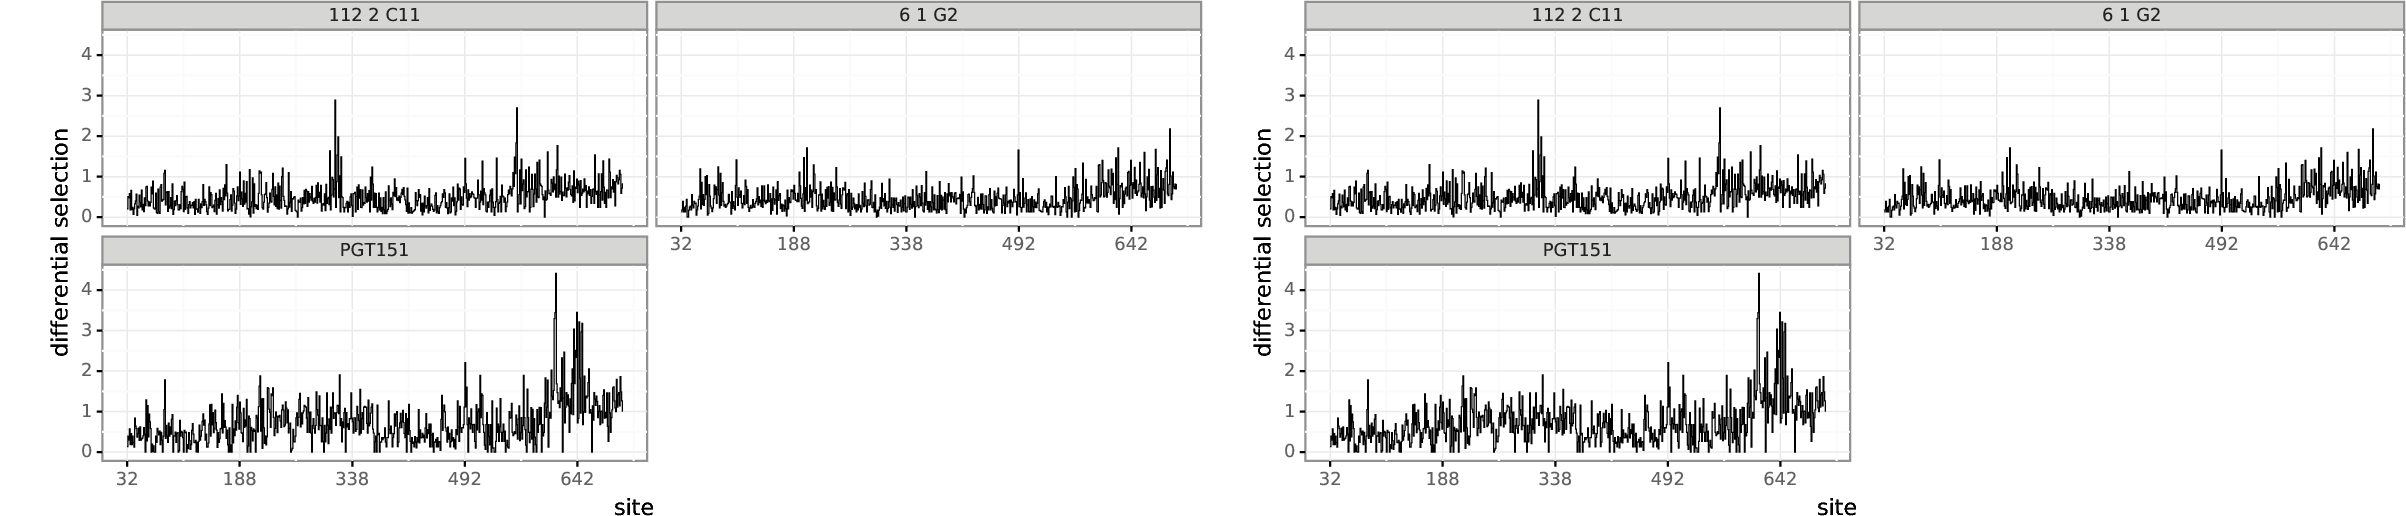

In [39]:
showPDF([diffselprefix + 'meanmaxdiffsel.pdf', diffselprefix + 'medianmaxdiffsel.pdf'])

For the PGT151 selection: Below, I am writing data from single residue mapping of PGT151 in the LAI JRCSF and LAI backgrounds from [*Falkowska et al., Immunity 2014*](http://www.sciencedirect.com/science/article/pii/S107476131400123X). I am writing the logbase2 fold change in IC50 realtive to wildtype that a mutation at each tested site imparts on PGT151 neutralization in a TZM-bl assay (data provided in the supplement of the above cited paper). If multiple mutations were tested at a site, the mutation that results in a large change is used. Since the two strains had different maximum endpoints, I took the lower of the two (115-fold change) as the maximum effect of a single mutations, such that the effects are plotted on the same scale (this affects few sites). 

## Make logo plots visualizing the differential selection 
TThe plots above summarize the site or maximum mutation differential selection using line plots. But the most comprehensive way to show this selection is in the form of logo plots that can be created with [dms2_logoplot](https://jbloomlab.github.io/dms_tools2/dms2_logoplot.html).

We make those logo plots using the mean mutation differential selection values returned by [dms2_batch_diffsel](https://jbloomlab.github.io/dms_tools2/dms2_batch_diffsel.html). 

For PGT151, we can also add underlays of the wildtype sequence and data from the original mapping of PGT151 done by [Falkowska et al 2014](http://www.sciencedirect.com/science/article/pii/S107476131400123X). 
In an impressive tour-de-force, they did TZM-bl neutralization of assays using large panels pseudoviruses bearing single mutants (usually to alanine) in two seperate viral strains, LAI and JR-CSF. 
In the underlays, if a box is colored at all, a mutation at that site was tested. 
It is colored according to the log2 fold-change in IC50 relative to wildtype imparted by that mutation. 
If multiple mutations were tested at a site, the mutation that results in a large change is used. 
Since the two strains had different maximum endpoints, we use the lower of the two (115-fold change) as the maximum effect of a single mutations, such that the effects are plotted on the same scale (this affects few sites). 
The effects of mutations in the JRCSF strain are in the file [./data/JRCSFalaninescandata_logbase2_115foldlimit.csv](./data/JRCSFalaninescandata_logbase2_115foldlimit.csv).
The effects of mutations in the LAI strain are in the file [./data/LAIalaninescandata_logbase2.csv](./data/LAIalaninescandata_logbase2.csv).

We will also add similar data for the DARPins.

To add the wildtype sequence, we can simply specify an overlay file with the columns wildtype and site -- any of our mutdiffsel files suffice. 
Note that we use the `--underlay yes` option since underlays look better than overlays here.

In [31]:
names = diffselbatch['name']
#print(names)
names = names.tolist()
#names

./results/diffsel/PGT151-1ug_diffsel.pdf

Creating logo plot for PGT151-1ug from ./results/diffsel/PGT151-1ug_mutdiffsel.csv


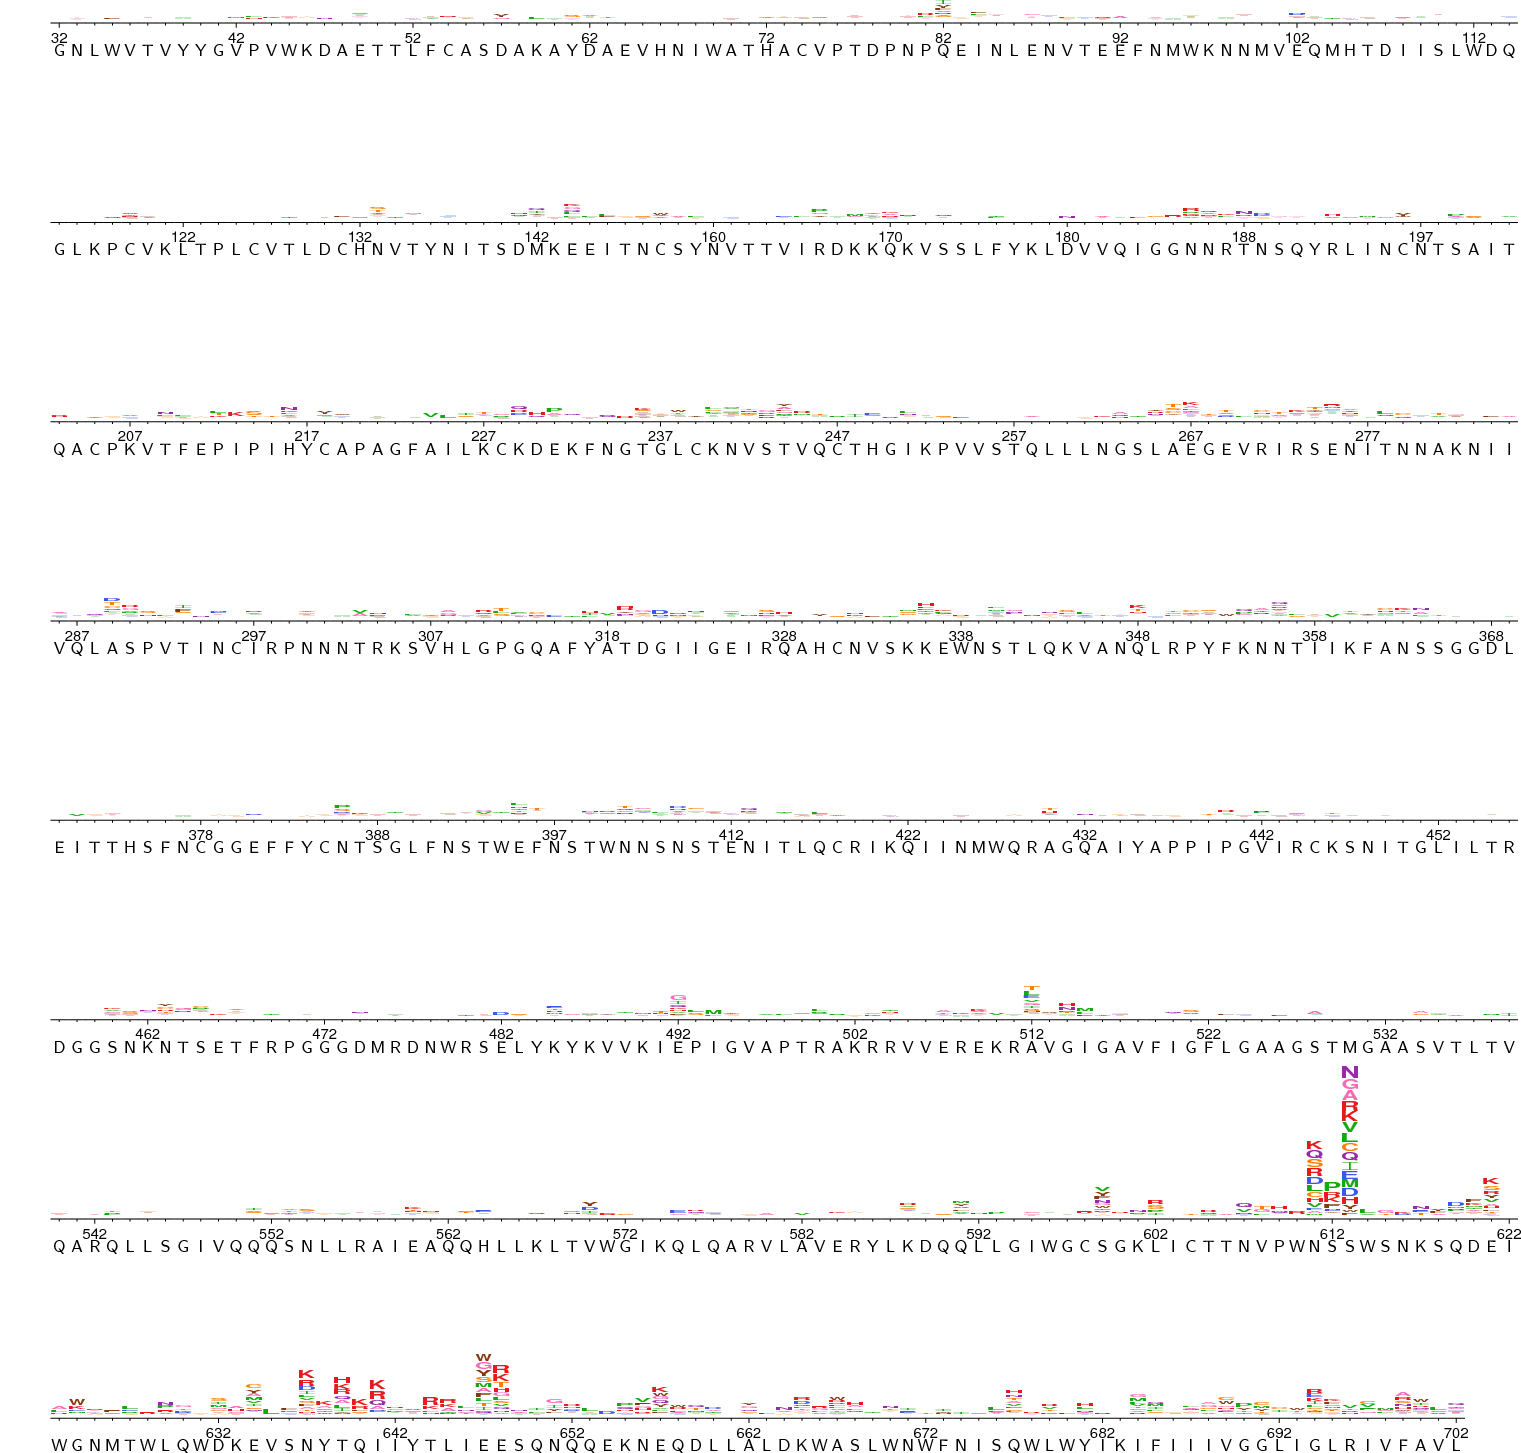

./results/diffsel/6-1-G2-0-17uM_diffsel.pdf

Creating logo plot for 6-1-G2-0-17uM from ./results/diffsel/6-1-G2-0-17uM_mutdiffsel.csv


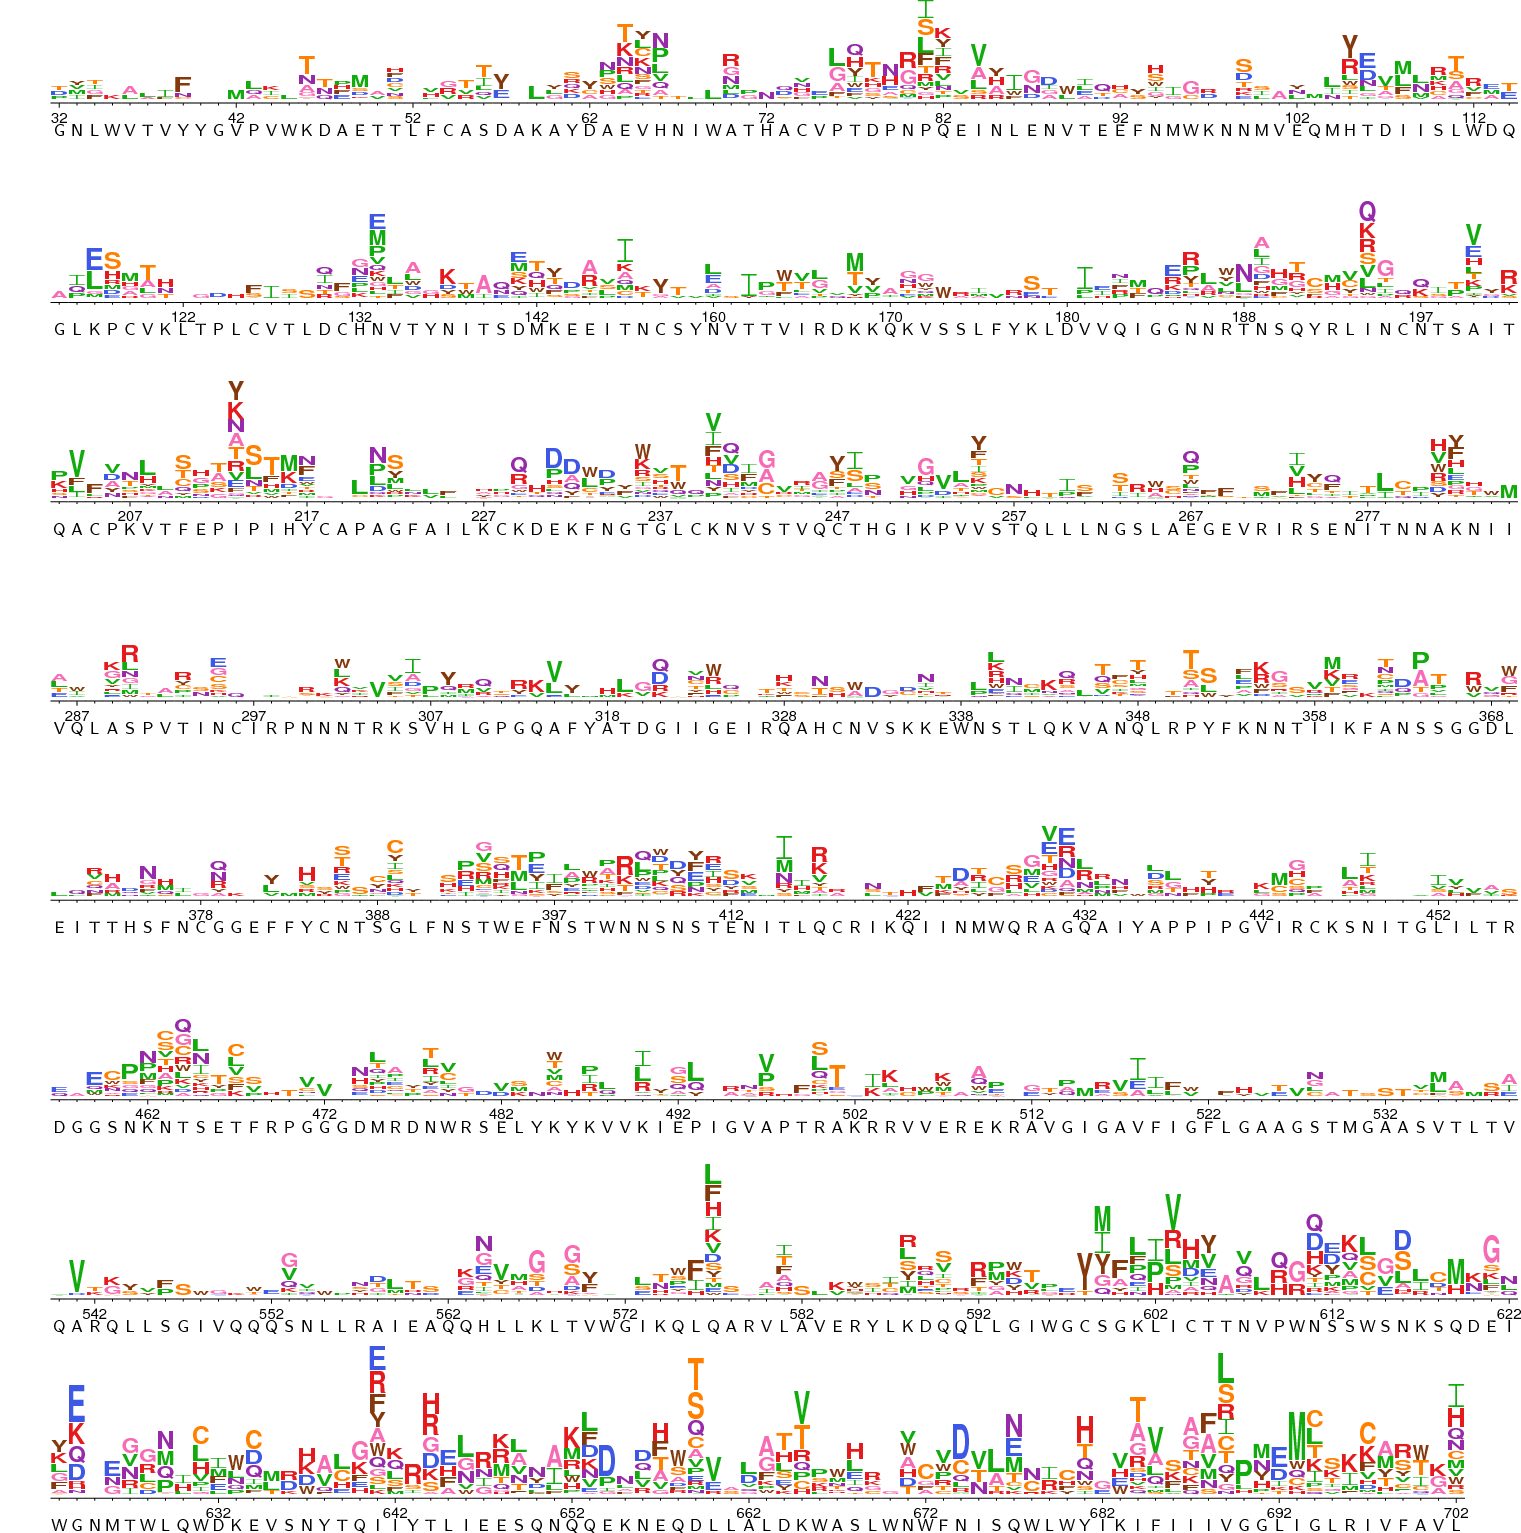

./results/diffsel/6-1-G2-0-56uM_diffsel.pdf

Creating logo plot for 6-1-G2-0-56uM from ./results/diffsel/6-1-G2-0-56uM_mutdiffsel.csv


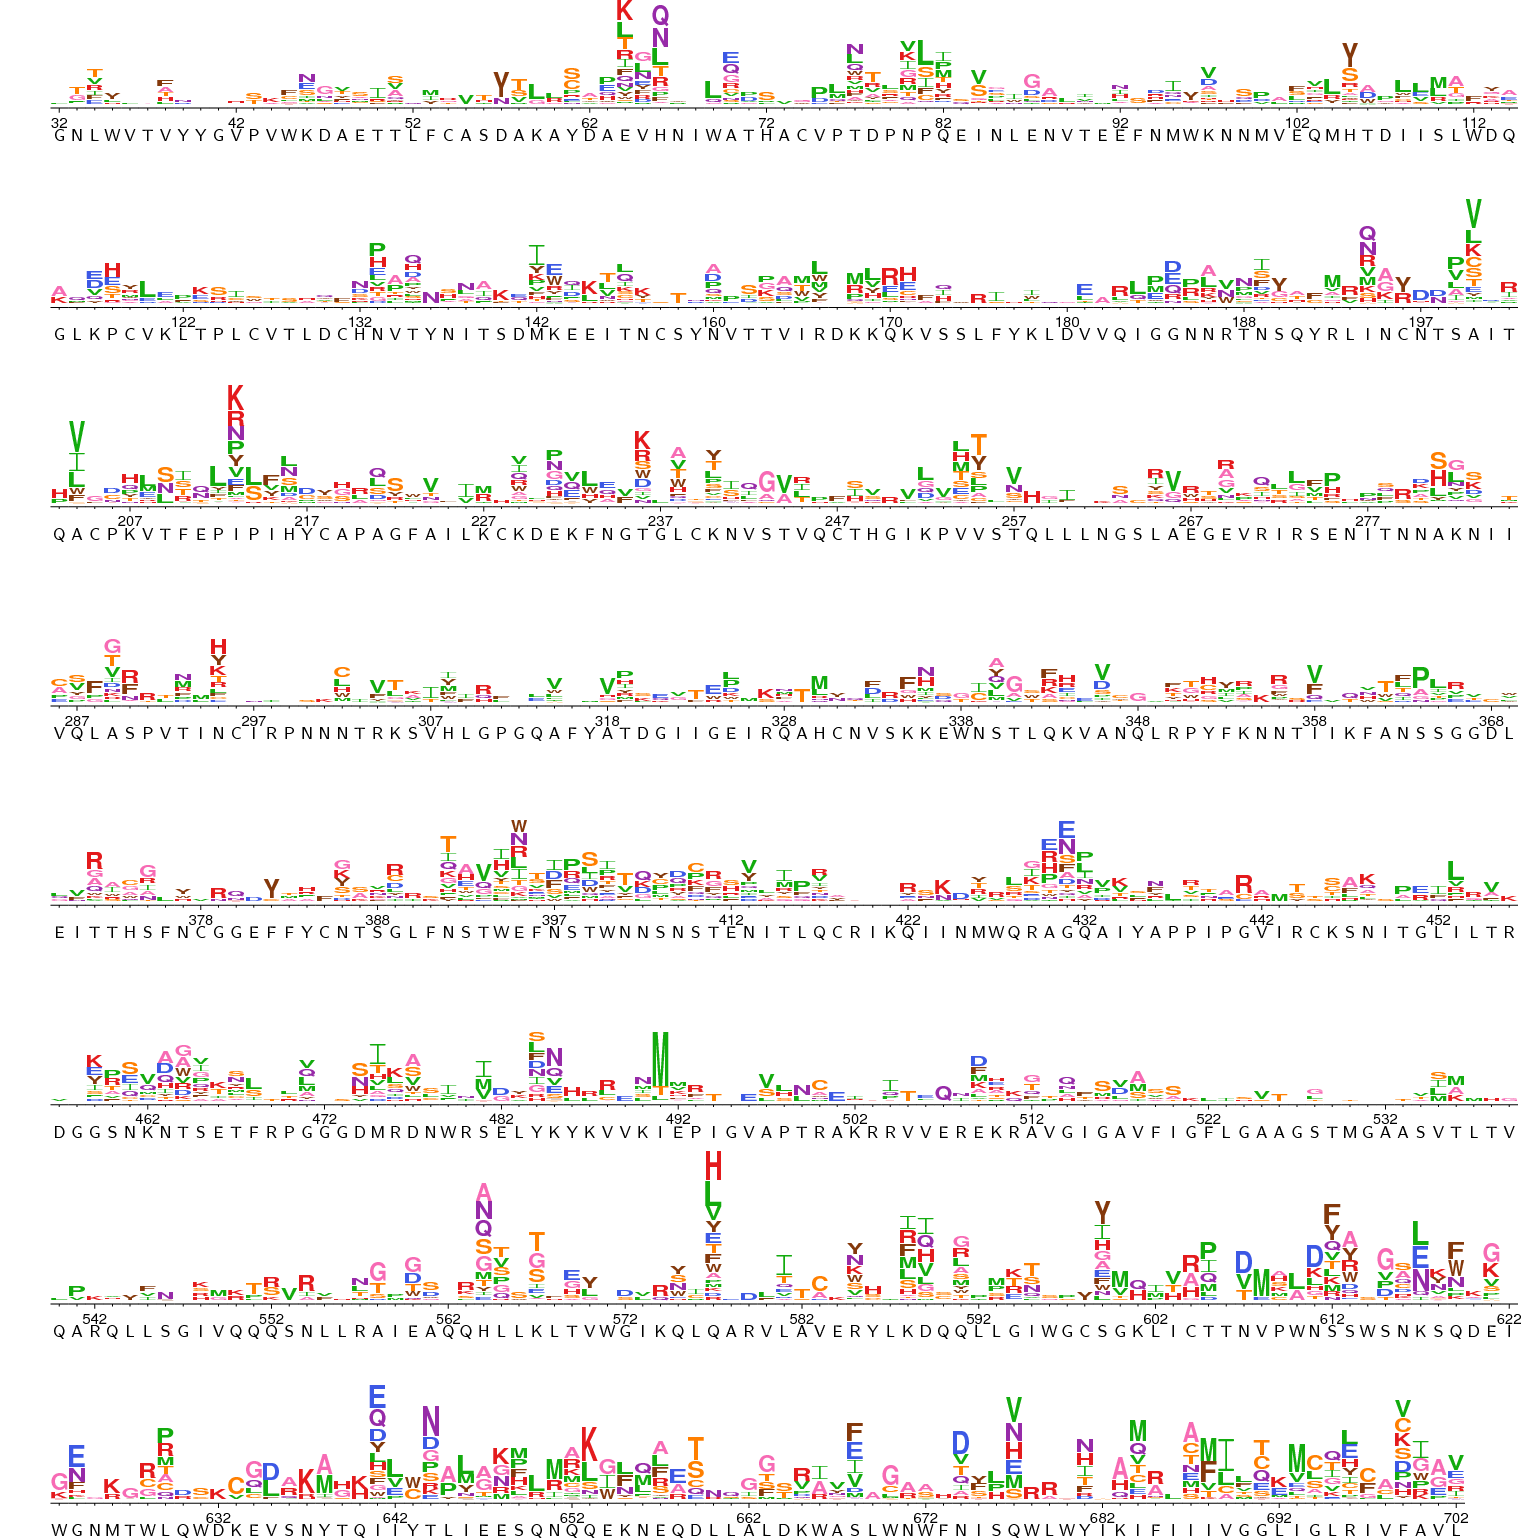

./results/diffsel/112-2-C11-0-17uM_diffsel.pdf

Creating logo plot for 112-2-C11-0-17uM from ./results/diffsel/112-2-C11-0-17uM_mutdiffsel.csv


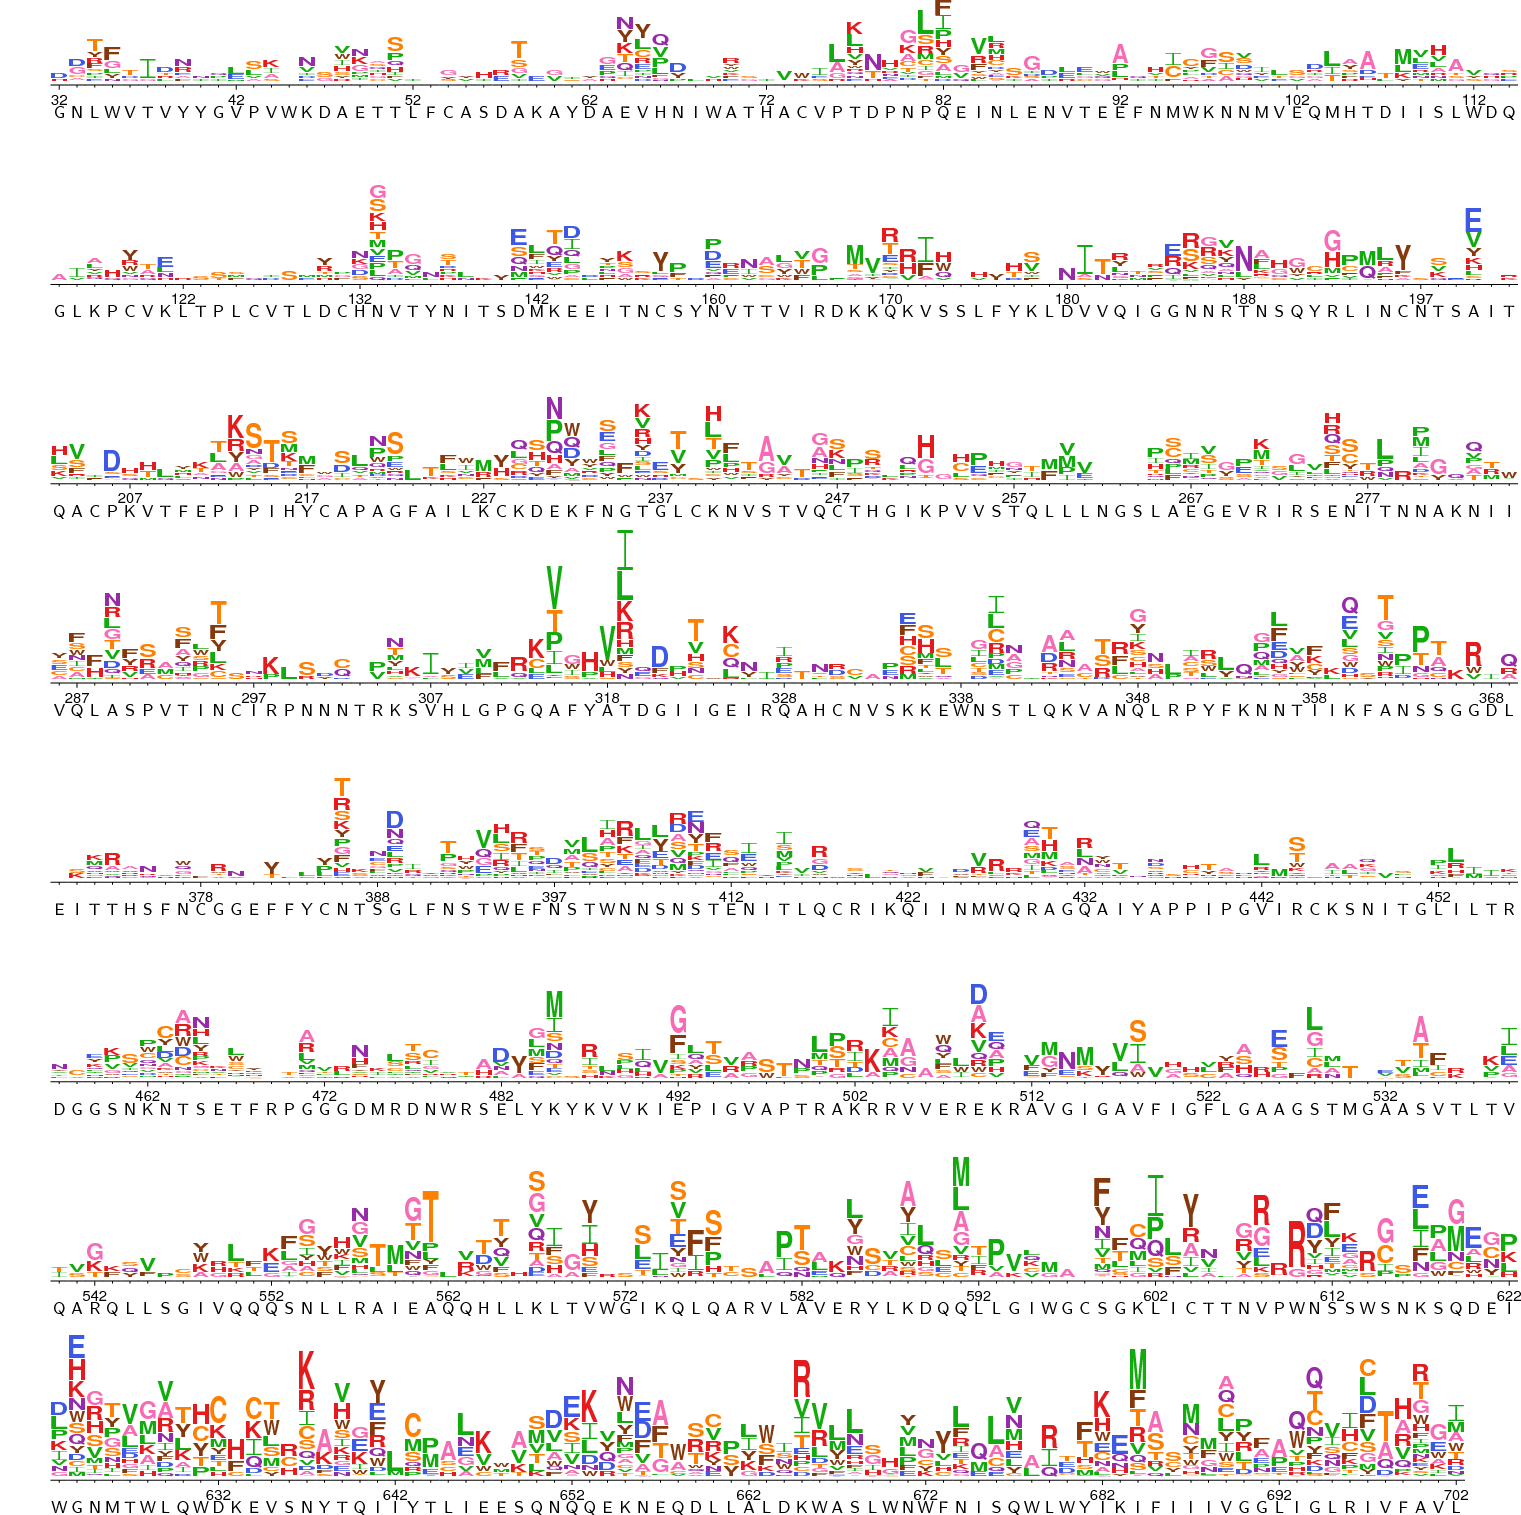

./results/diffsel/112-2-C11-0-56uM_diffsel.pdf

Creating logo plot for 112-2-C11-0-56uM from ./results/diffsel/112-2-C11-0-56uM_mutdiffsel.csv


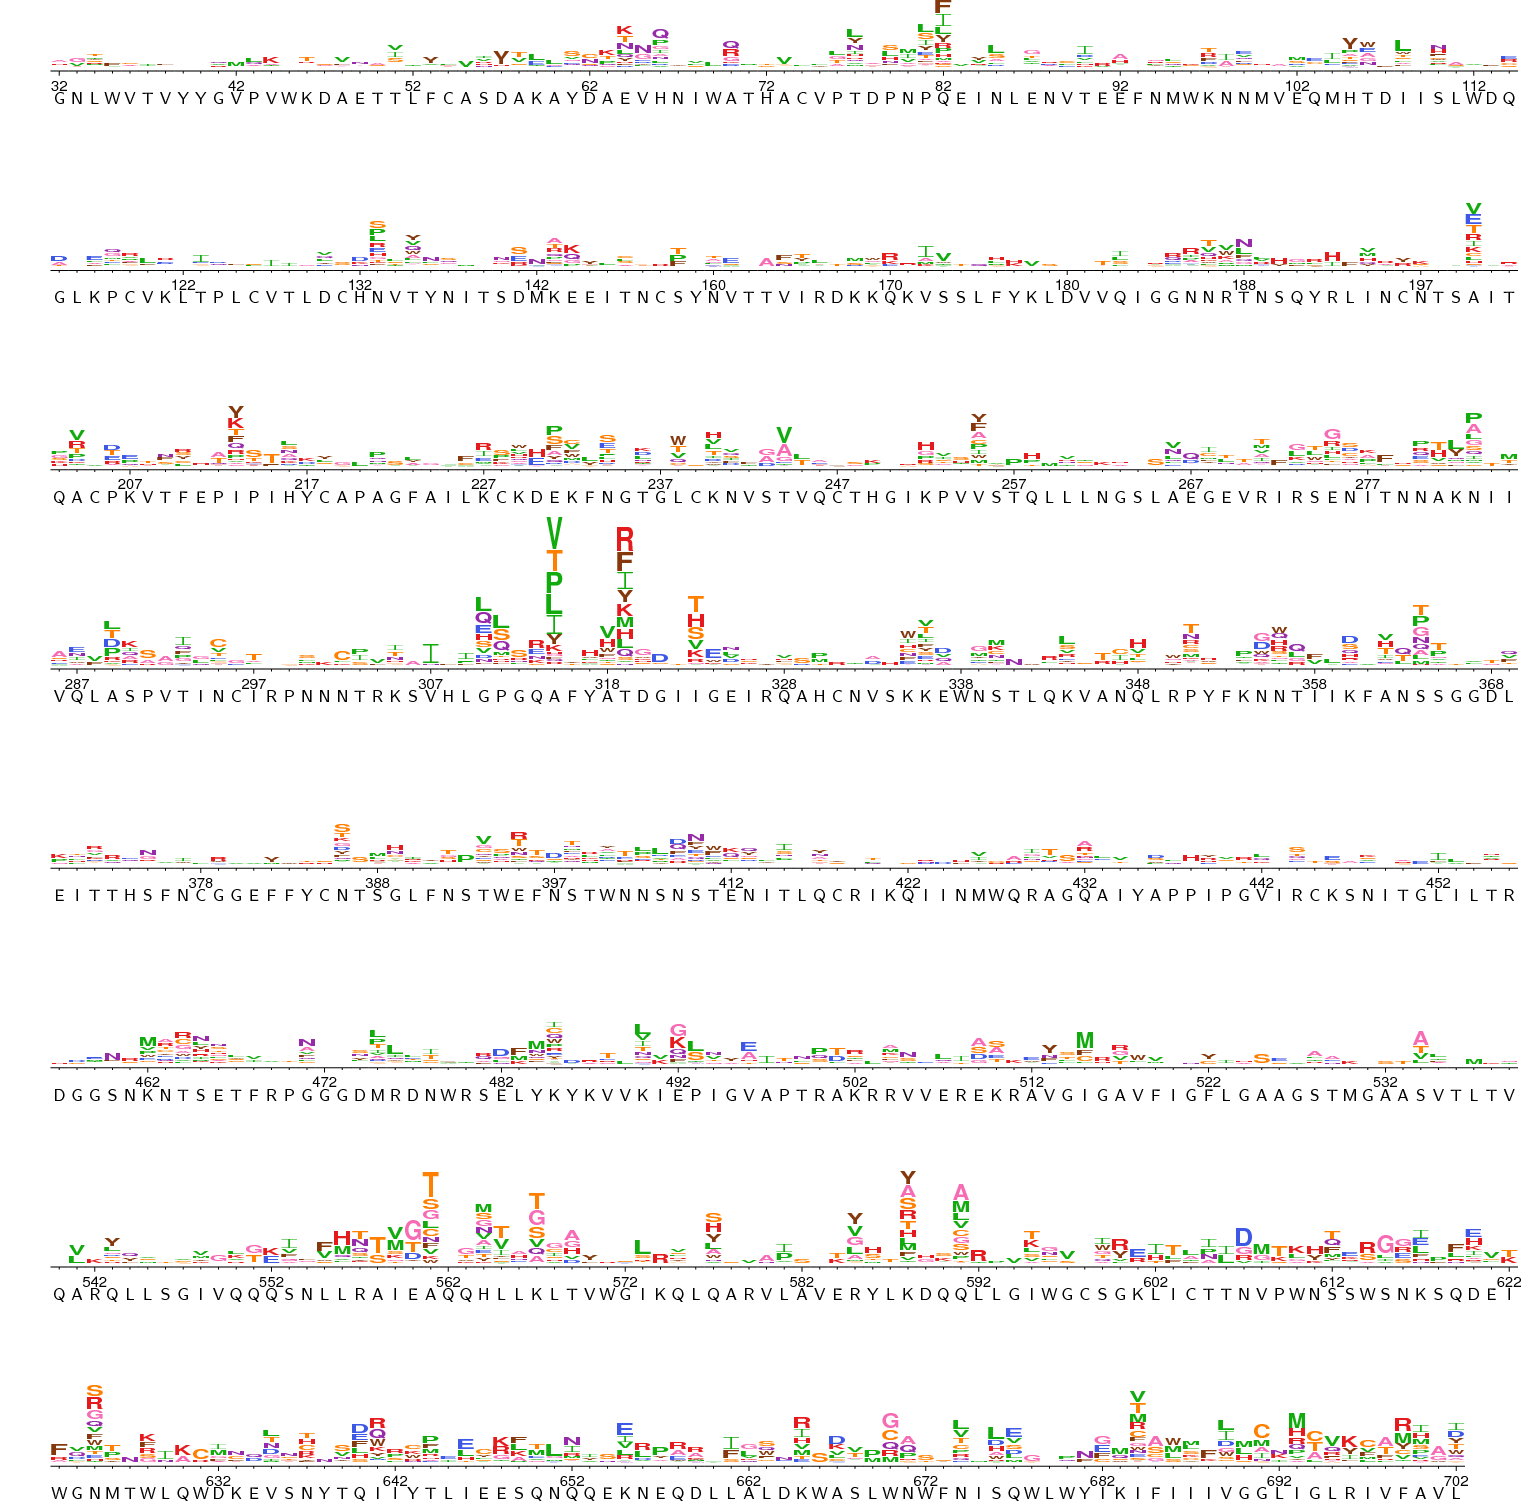

In [17]:
#plotting all logoplots without underlays first.

#overlay_cmap = 'YlOrRd'
#JRCSF = 'JRCSFalaninescandata_logbase2_115foldlimit.csv'
#LAI = 'LAIalaninescandata_logbase2.csv'
          
for antibody in names:
    # mutdiffsel in this file
    #mutdiffsel =  antibody + '_mutdiffsel.csv'
    mutdiffsel = os.path.join(diffseldir, '{0}_mutdiffsel.csv'.format(antibody))
    # now create the logo plot with the overlay
    logoplot = os.path.join(diffseldir, '{0}_diffsel.pdf'.format(antibody))
    print(logoplot)
    print("\nCreating logo plot for {0} from {1}".format(antibody, mutdiffsel))
    log = !dms2_logoplot \
            --diffsel {mutdiffsel} \
            --name {antibody} \
            --outdir {diffseldir} \
            --restrictdiffsel positive \
            --sepline no \
            --nperline 83 \
            --overlay1 {mutdiffsel} wildtype wildtype \
            --underlay yes \
            --use_existing {use_existing}
    showPDF(logoplot)

./results/diffsel/avg_across_concentrations/6-1-G2_diffsel.pdf

Creating logo plot for 6-1-G2 from ./results/diffsel/avg_across_concentrations/summary_6-1-G2-meanmutdiffsel.csv


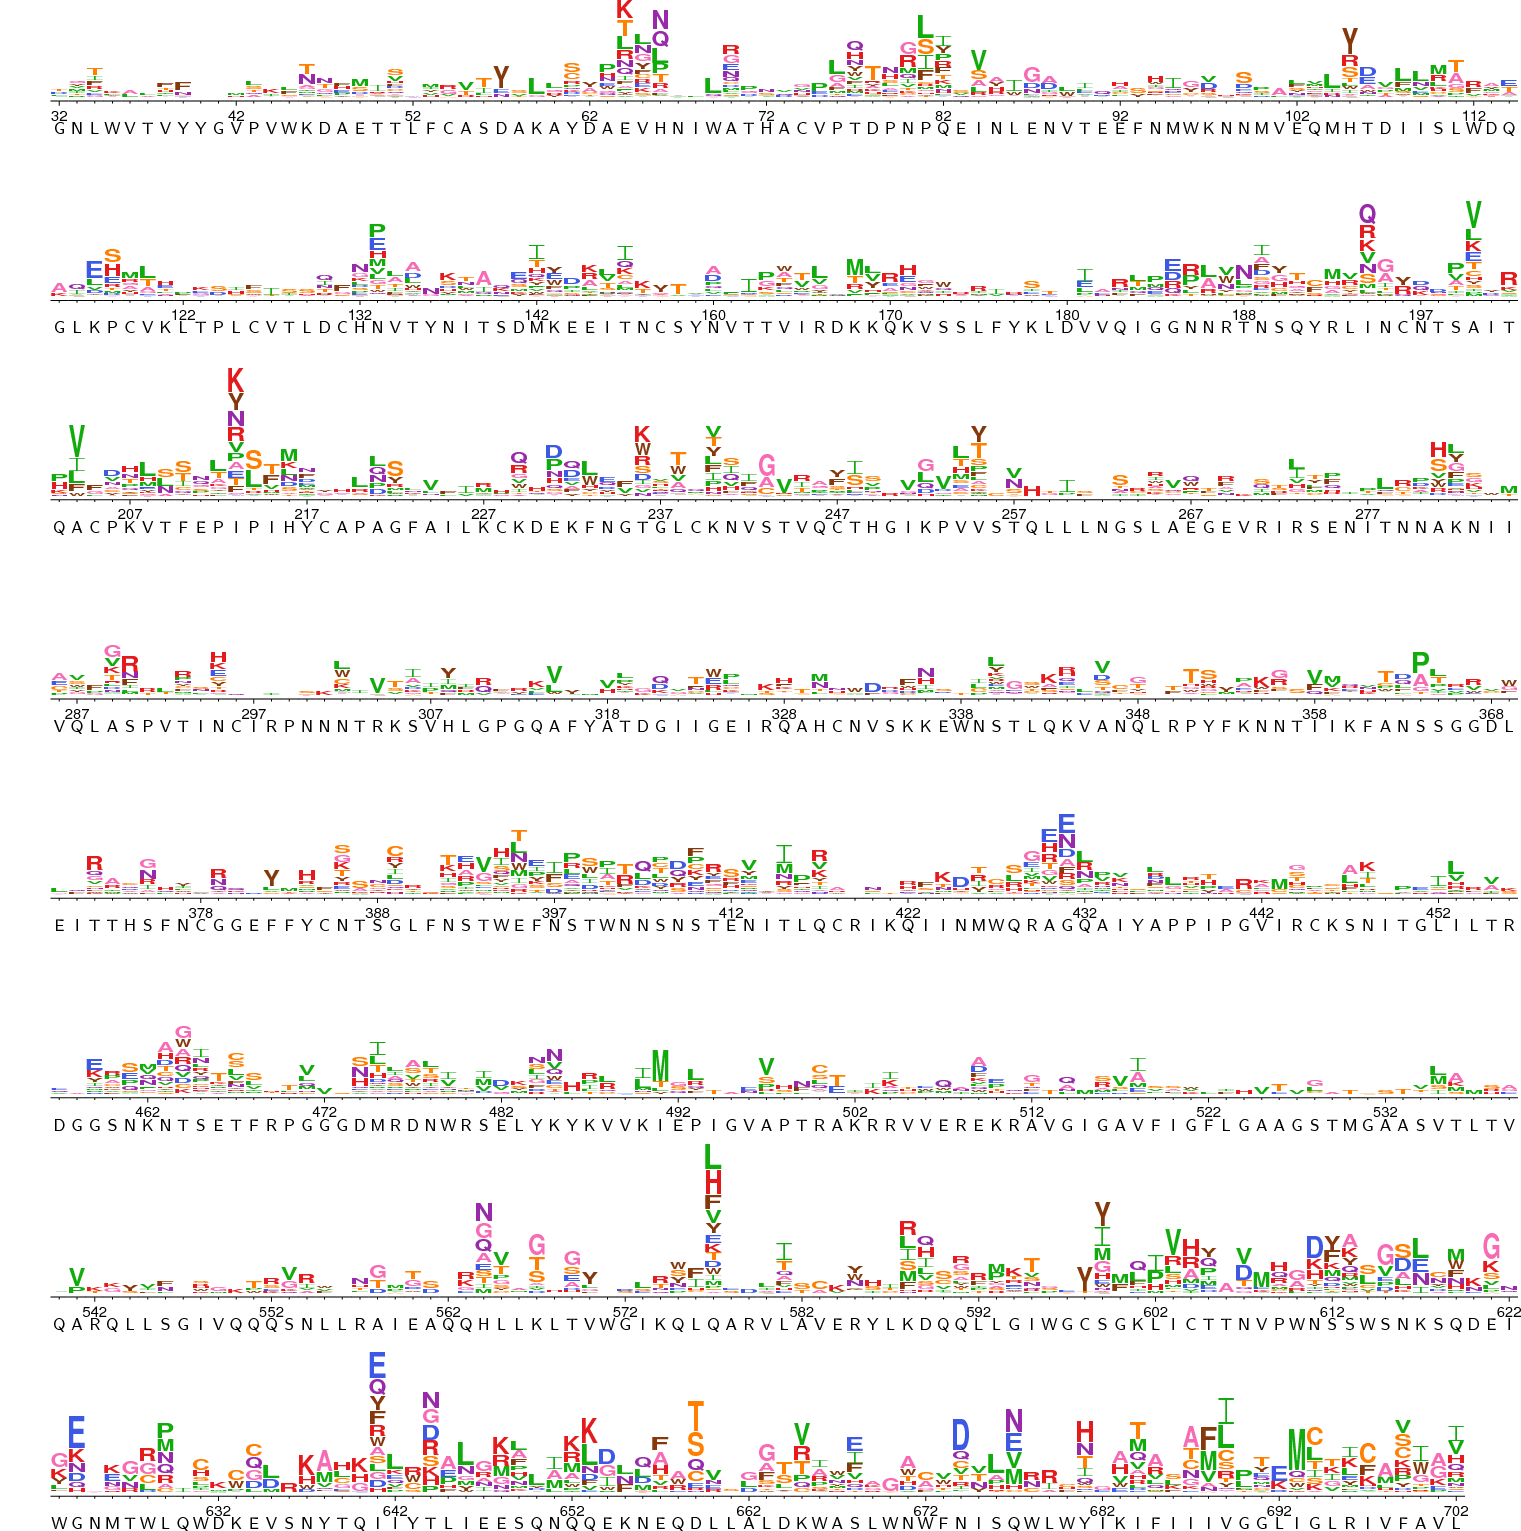

./results/diffsel/avg_across_concentrations/112-2-C11_diffsel.pdf

Creating logo plot for 112-2-C11 from ./results/diffsel/avg_across_concentrations/summary_112-2-C11-meanmutdiffsel.csv


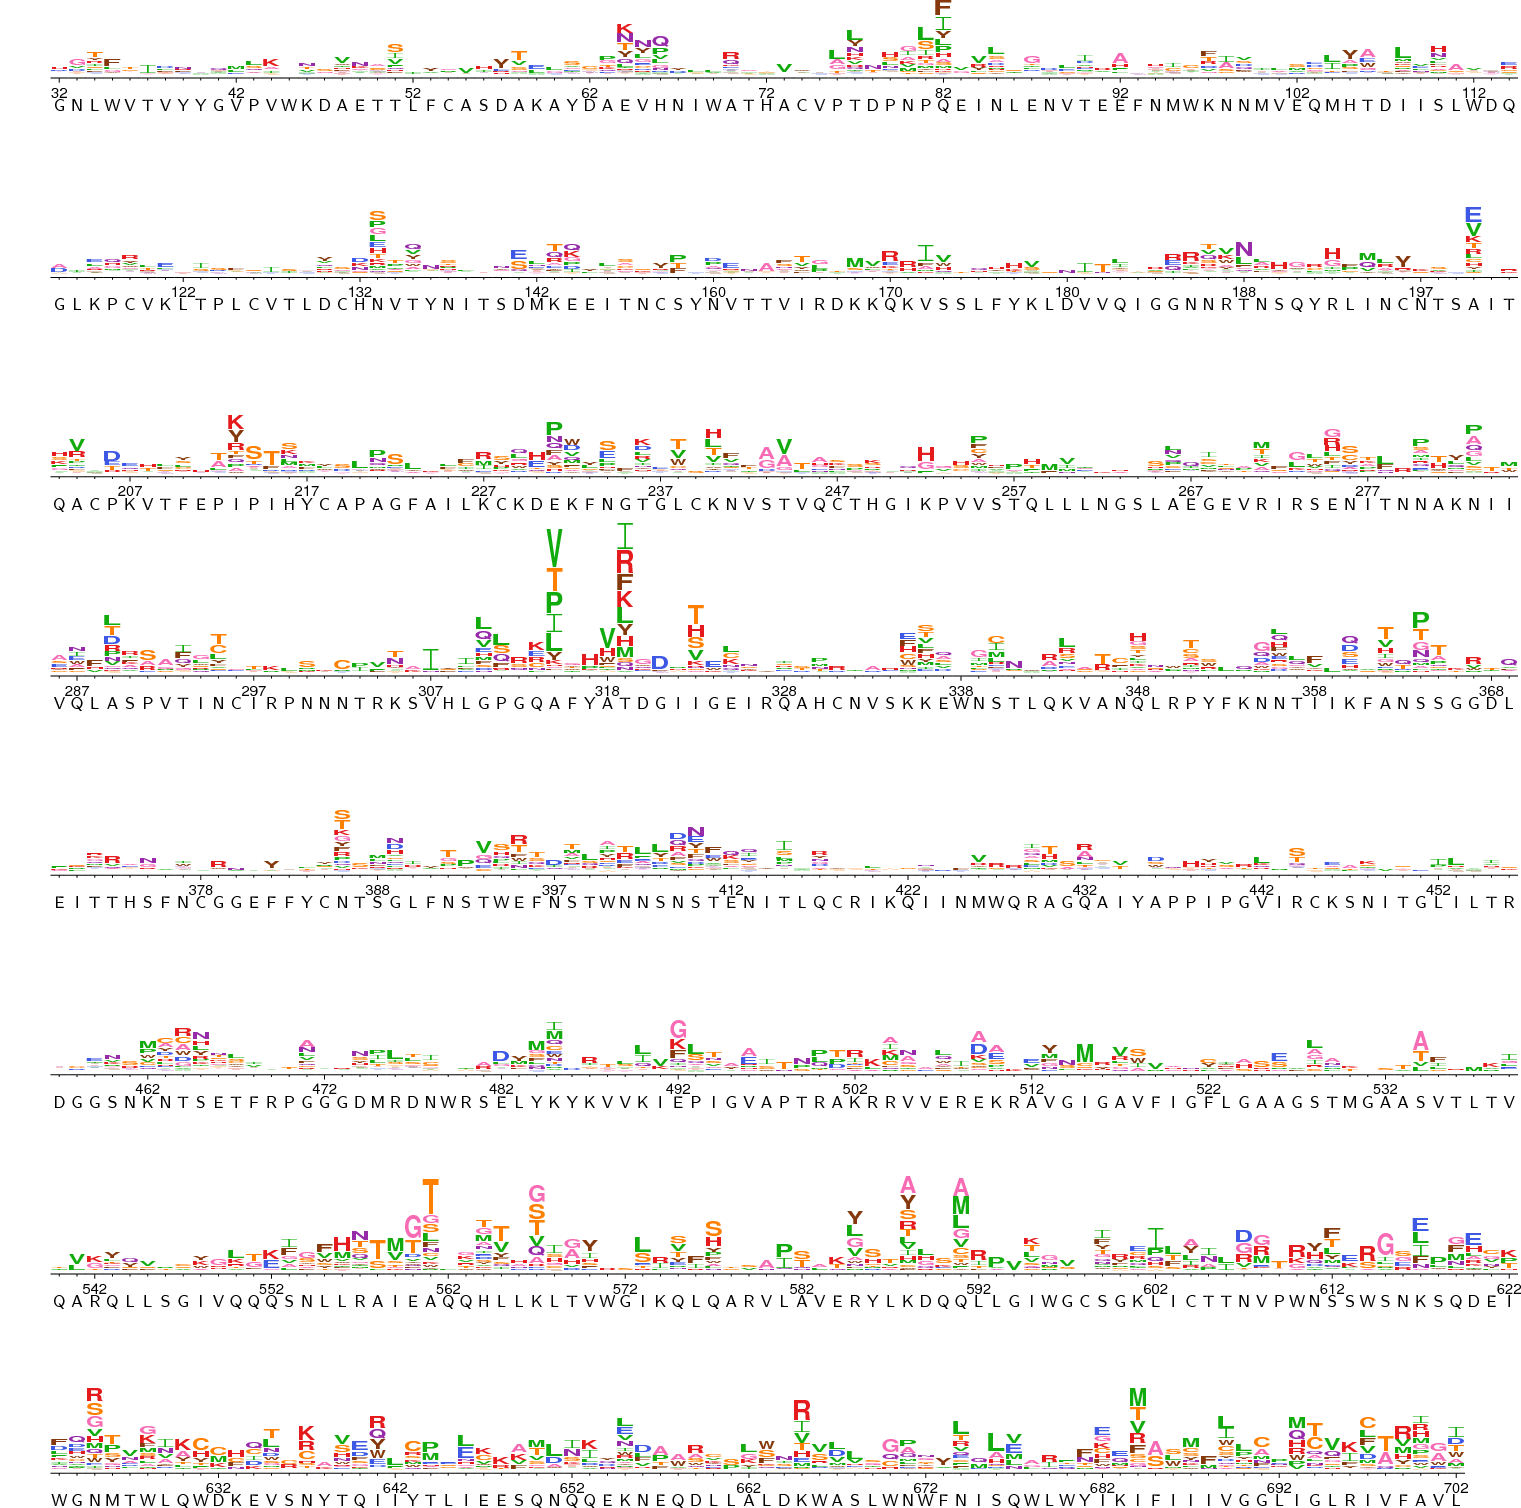

In [20]:
#now, we will make logoplots of the selection averaged across the two concentrations of each DARPin

groupnames = ['6-1-G2', '112-2-C11']
for antibody in groupnames:
    # mutdiffsel in this file
    #mutdiffsel =  antibody + '_mutdiffsel.csv'
    mutdiffsel = os.path.join(avgconcdiffseldir, 'summary_{0}-meanmutdiffsel.csv'.format(antibody))
    # now create the logo plot with the overlay
    logoplot = os.path.join(avgconcdiffseldir, '{0}_diffsel.pdf'.format(antibody))
    print(logoplot)
    print("\nCreating logo plot for {0} from {1}".format(antibody, mutdiffsel))
    log = !dms2_logoplot \
            --diffsel {mutdiffsel} \
            --name {antibody} \
            --outdir {avgconcdiffseldir} \
            --restrictdiffsel positive \
            --sepline no \
            --nperline 83 \
            --overlay1 {mutdiffsel} wildtype wildtype \
            --underlay yes \
            --use_existing {use_existing}
    showPDF(logoplot)

./results/diffsel/avg_across_concentrations/6-1-G2-annotated_diffsel.pdf

Creating logo plot for 6-1-G2 from ./results/diffsel/avg_across_concentrations/summary_6-1-G2-meanmutdiffsel.csv


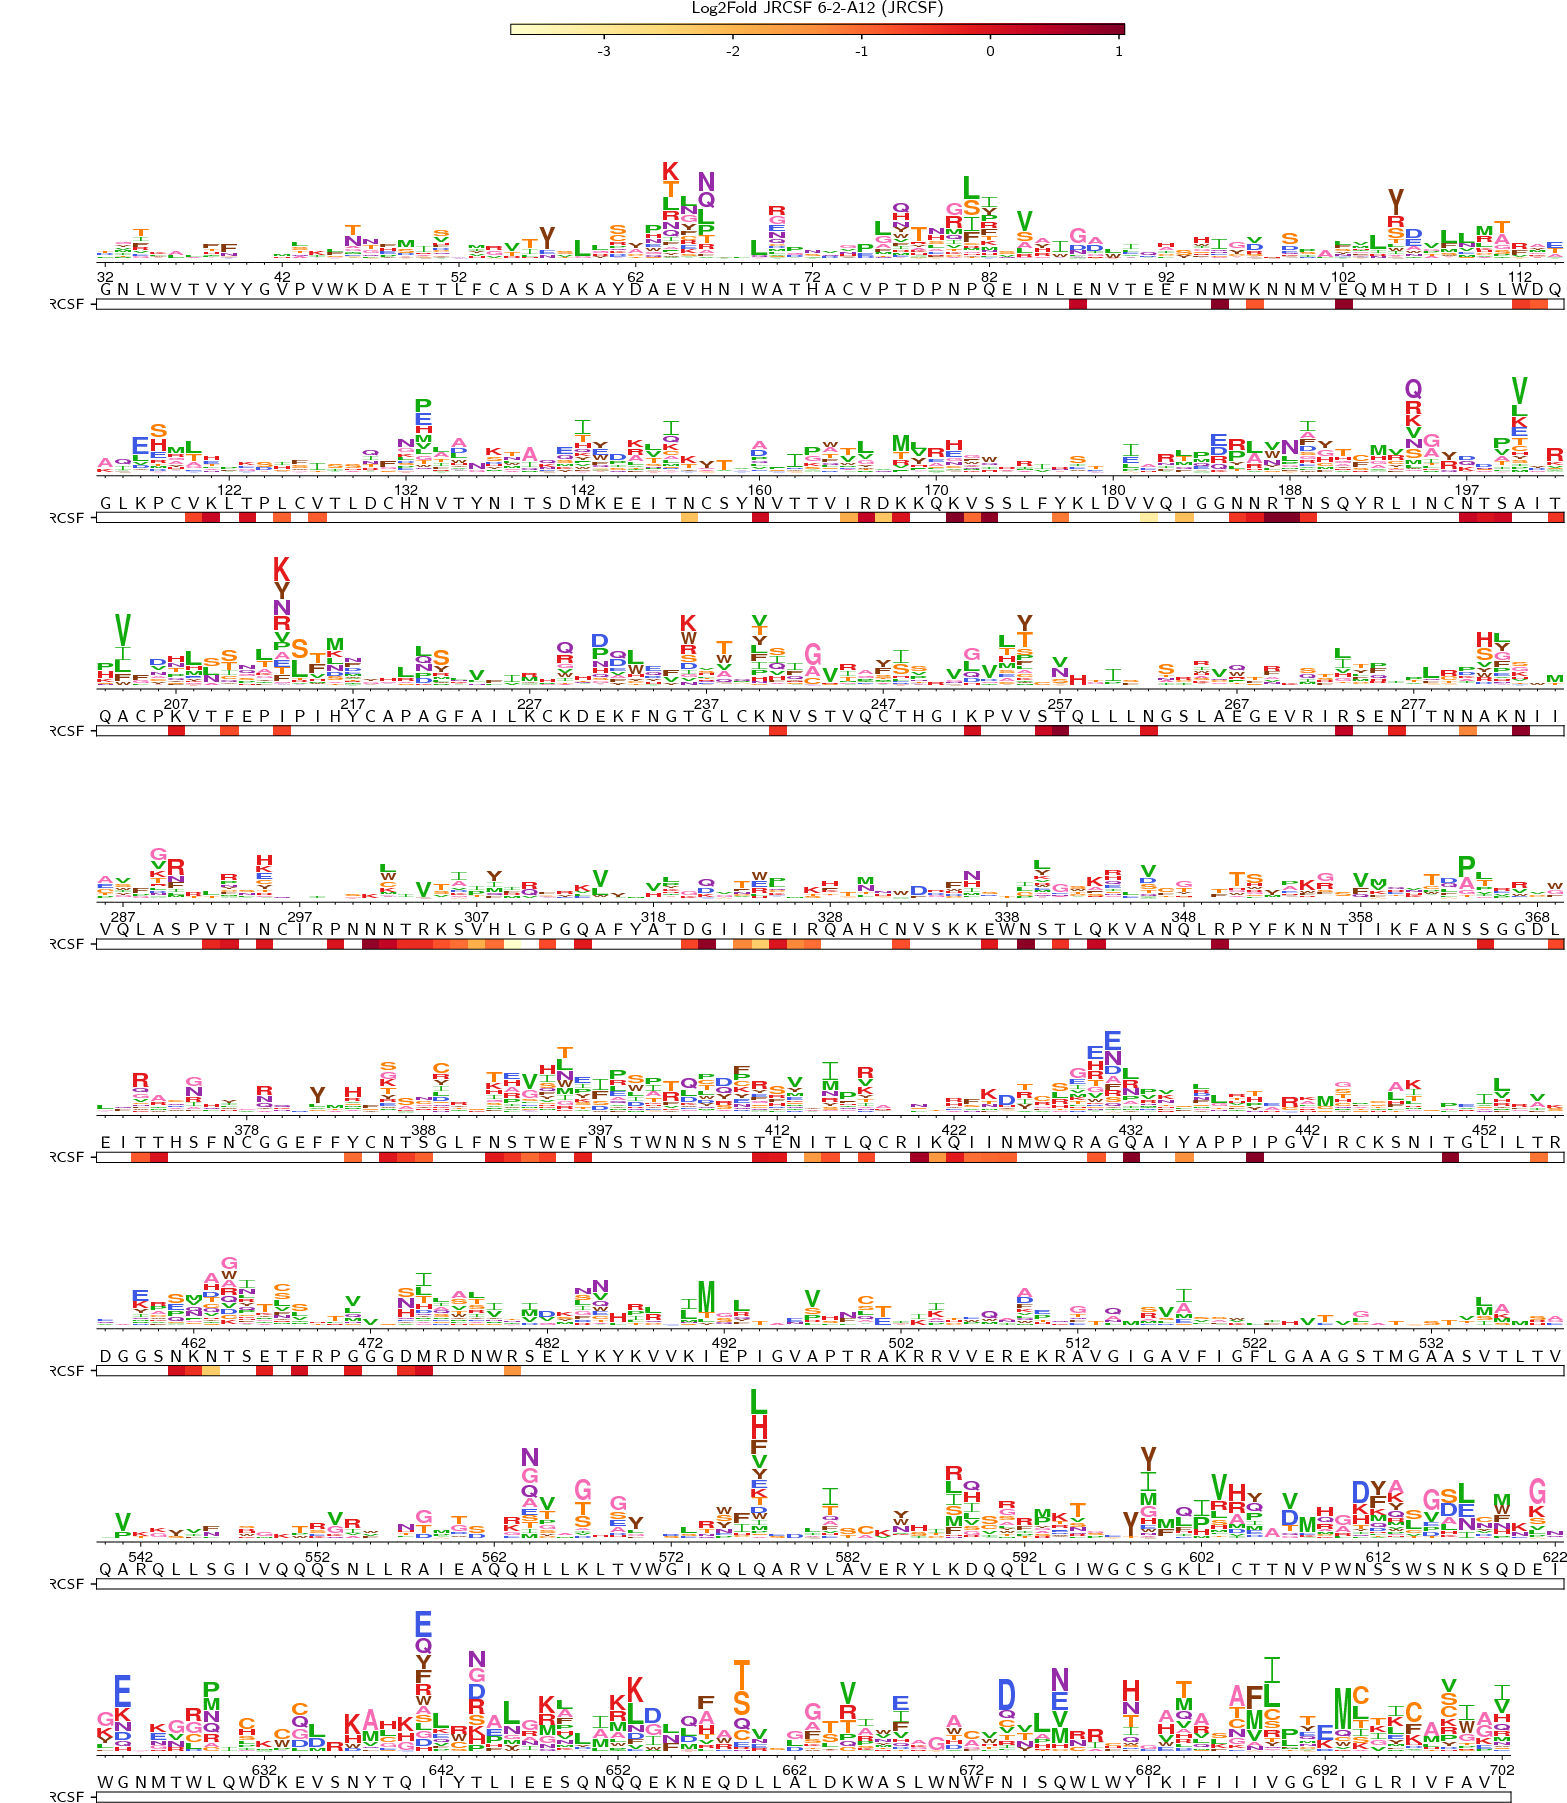

In [36]:
#now, we add overlays to avg data one by one
groupnames = ['6-1-G2']
JRCSFascandata = "./data/6_2_A12_JRCSF_logbase2.csv"
for antibody in groupnames:
    # mutdiffsel in this file
    #mutdiffsel =  antibody + '_mutdiffsel.csv'
    mutdiffsel = os.path.join(avgconcdiffseldir, 'summary_{0}-meanmutdiffsel.csv'.format(antibody))
    # now create the logo plot with the overlay
    logoplot = os.path.join(avgconcdiffseldir, '{0}-annotated_diffsel.pdf'.format(antibody))
    name = "{0}-annotated".format(antibody)
    print(logoplot)
    print("\nCreating logo plot for {0} from {1}".format(antibody, mutdiffsel))
    log = !dms2_logoplot \
            --diffsel {mutdiffsel} \
            --name {name} \
            --outdir {avgconcdiffseldir} \
            --restrictdiffsel positive \
            --sepline no \
            --overlaycolormap YlOrRd \
            --nperline 83 \
            --overlay1 {mutdiffsel} wildtype wildtype \
            --overlay2 {JRCSFascandata} JRCSF "Log2Fold JRCSF 6-2-A12" \
            --underlay yes \
            --use_existing {use_existing}
    showPDF(logoplot)

./results/diffsel/avg_across_concentrations/112-2-C11-annotated_diffsel.pdf

Creating logo plot for 112-2-C11 from ./results/diffsel/avg_across_concentrations/summary_112-2-C11-meanmutdiffsel.csv


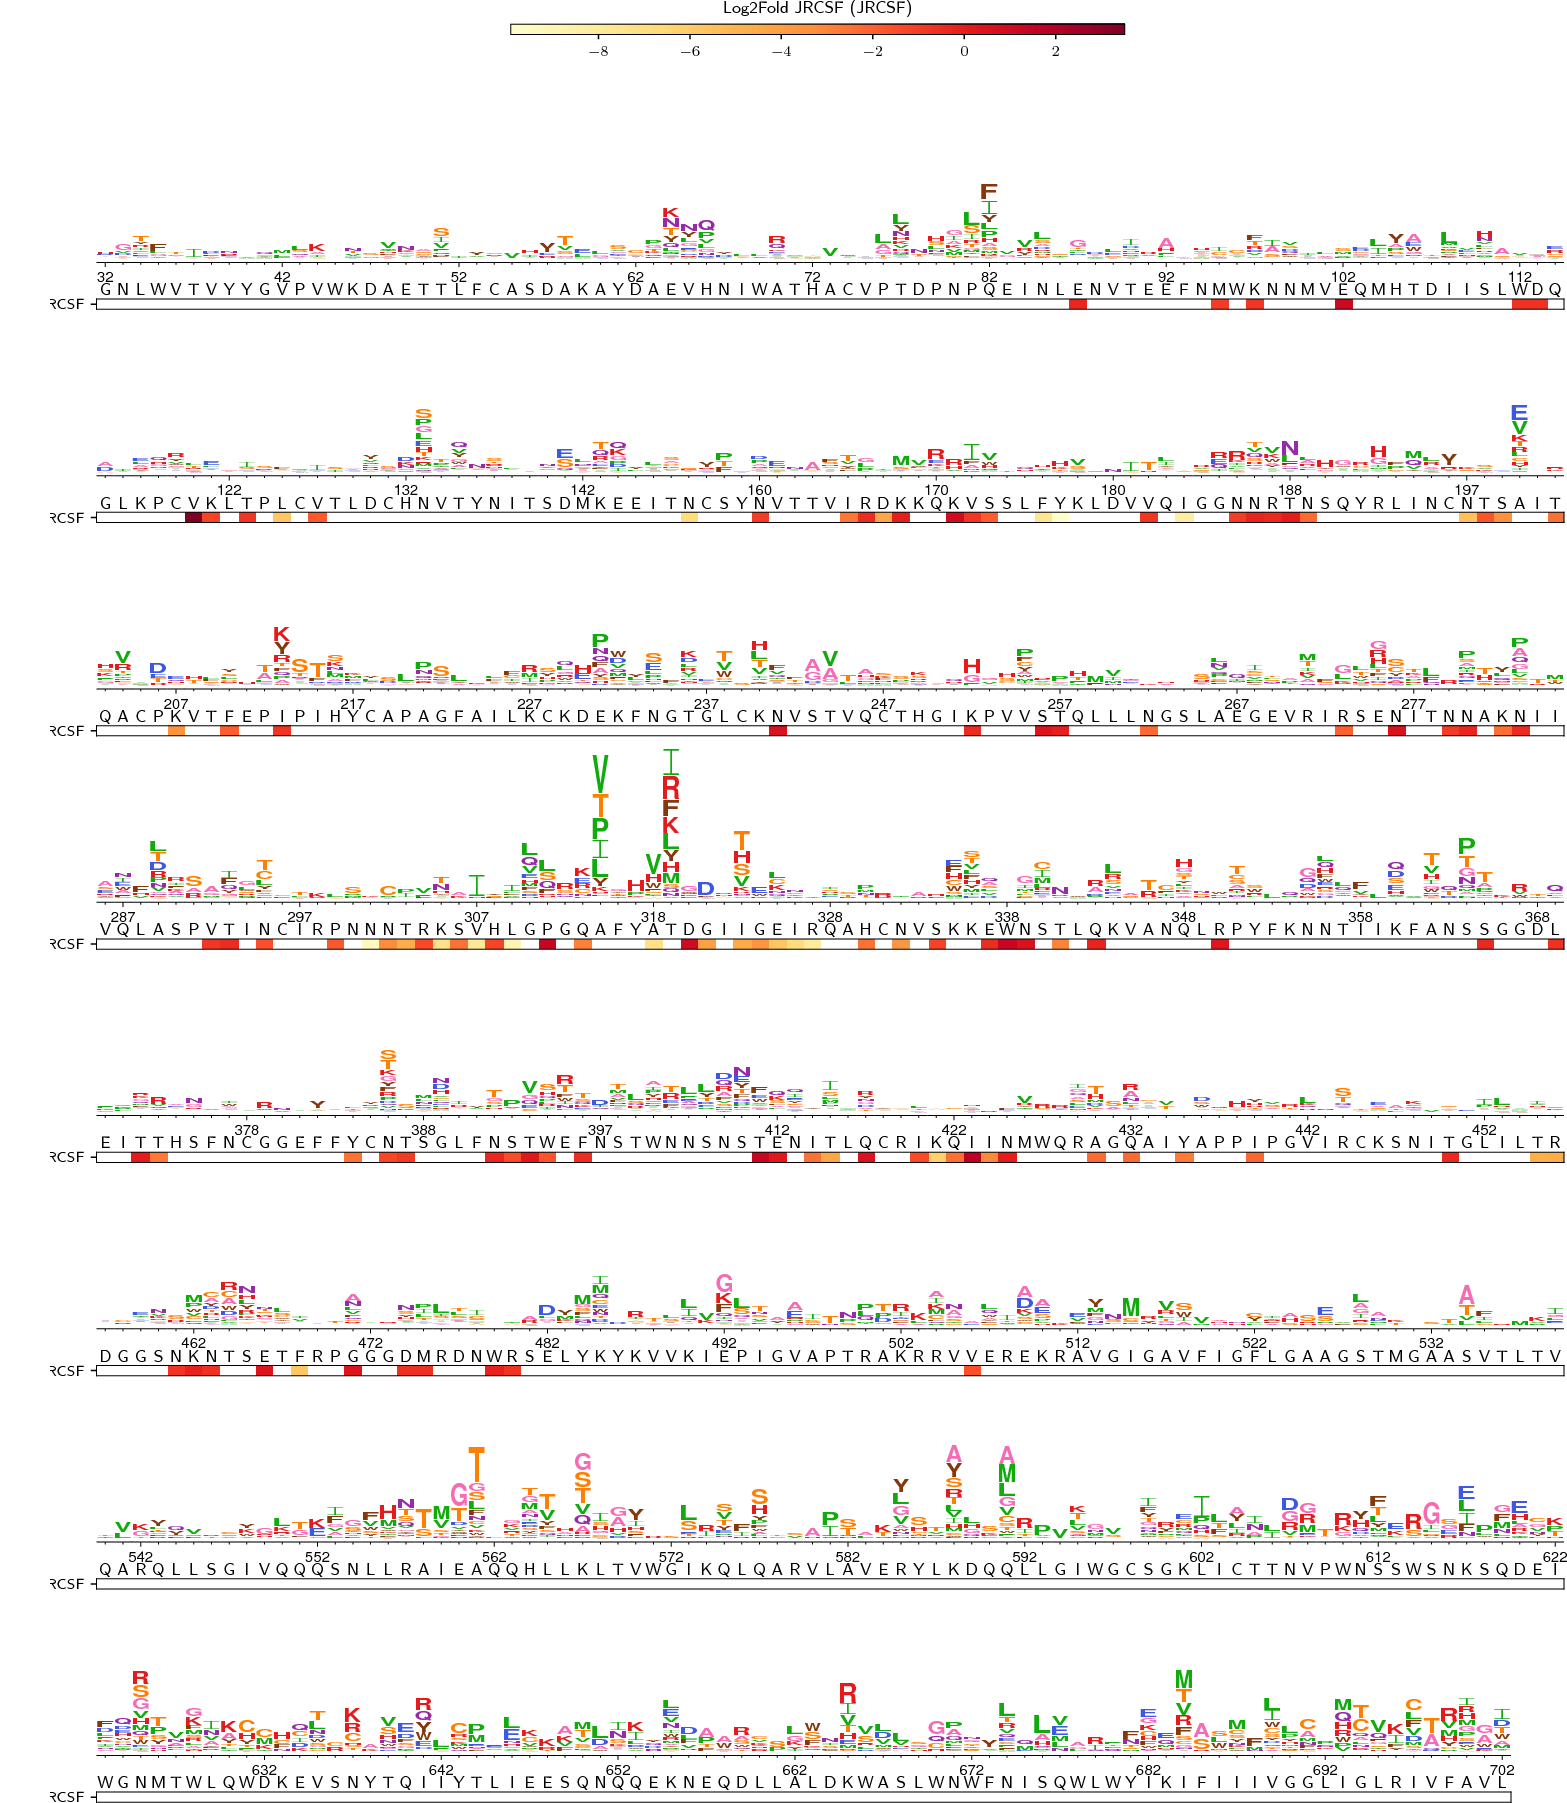

In [38]:
#now, we add overlays to avg data one by one
groupnames = ['112-2-C11']
JRCSFascandata = "./data/112_2_c11_JRCSF_logbase2.csv"
for antibody in groupnames:
    # mutdiffsel in this file
    #mutdiffsel =  antibody + '_mutdiffsel.csv'
    mutdiffsel = os.path.join(avgconcdiffseldir, 'summary_{0}-meanmutdiffsel.csv'.format(antibody))
    # now create the logo plot with the overlay
    logoplot = os.path.join(avgconcdiffseldir, '{0}-annotated_diffsel.pdf'.format(antibody))
    name = "{0}-annotated".format(antibody)
    print(logoplot)
    print("\nCreating logo plot for {0} from {1}".format(antibody, mutdiffsel))
    log = !dms2_logoplot \
            --diffsel {mutdiffsel} \
            --name {name} \
            --outdir {avgconcdiffseldir} \
            --restrictdiffsel positive \
            --sepline no \
            --overlaycolormap YlOrRd \
            --nperline 83 \
            --overlay1 {mutdiffsel} wildtype wildtype \
            --overlay2 {JRCSFascandata} JRCSF "Log2Fold JRCSF" \
            --underlay yes \
            --use_existing {use_existing}
    showPDF(logoplot)